In [1]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import dotenv


2024-11-20 14:09:21.640808: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN


### Hyperparameters

In [2]:
# Load environment variables
dotenv.load_dotenv()

EPOCHS = 50
BATCH_SIZE = 128
IMAGE_SIZE = 128 

### Import Dataset

In [3]:
training_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Training')

class_labels = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
image_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels_reverse = {v: k for k, v in class_labels.items()}

In [4]:
# Initialize lists to store images and masks for the training dataset
images = []
masks = []

# Loop over the folders in the Training dataset to load images and their corresponding masks
for folder in image_folders:
    folder_path = os.path.join(training_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224 or any size you prefer

        # Create a dummy mask for segmentation (since the dataset is for classification, we generate synthetic masks for demonstration purposes)
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
        if folder == 'glioma':
            mask[50:150, 50:150] = 1  # Example synthetic mask for glioma
        elif folder == 'meningioma':
            mask[70:170, 70:170] = 1  # Example synthetic mask for meningioma
        elif folder == 'pituitary':
            mask[30:130, 30:130] = 1  # Example synthetic mask for pituitary
        elif folder == 'notumor':
            mask[:, :] = 0  # No mask for 'notumor'

        # Append image and mask (use list append method)
        images.append(img)
        masks.append(mask)

# Convert lists to numpy arrays after appending all images and masks
images = np.array(images)
masks = np.array(masks)

# Normalize the images (optional but helps with training)
images = images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for segmentation model
X_rgb = np.repeat(images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Normalize the masks
masks = masks.astype('float32')

# Expand mask dimensions to match output (batch, height, width, channels)
masks = np.expand_dims(masks, axis=-1)

# Split the dataset into training and validation sets (80% for training, 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_rgb, masks, test_size=0.2, random_state=42)

In [5]:
# Define the U-Net model for segmentation
def unet_model(input_size=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [6]:
# Create the U-Net model
model = unet_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            


 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             


 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              


 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            


 D)                                                                                               


 conv2d_2 (Conv2D)           (None, 64, 64, 128)          73856     ['max_pooling2d[0][0]']       


 conv2d_3 (Conv2D)           (None, 64, 64, 128)          147584    ['conv2d_2[0][0]']            


 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)          0         ['conv2d_3[0][0]']            


 g2D)                                                                                             


 conv2d_4 (Conv2D)           (None, 32, 32, 256)          295168    ['max_pooling2d_1[0][0]']     


 conv2d_5 (Conv2D)           (None, 32, 32, 256)          590080    ['conv2d_4[0][0]']            


 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 256)          0         ['conv2d_5[0][0]']            


 g2D)                                                                                             


 conv2d_6 (Conv2D)           (None, 16, 16, 512)          1180160   ['max_pooling2d_2[0][0]']     


 conv2d_7 (Conv2D)           (None, 16, 16, 512)          2359808   ['conv2d_6[0][0]']            


 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 512)            0         ['conv2d_7[0][0]']            


 g2D)                                                                                             


 conv2d_8 (Conv2D)           (None, 8, 8, 1024)           4719616   ['max_pooling2d_3[0][0]']     


 conv2d_9 (Conv2D)           (None, 8, 8, 1024)           9438208   ['conv2d_8[0][0]']            


 conv2d_transpose (Conv2DTr  (None, 16, 16, 512)          2097664   ['conv2d_9[0][0]']            


 anspose)                                                                                         


 concatenate (Concatenate)   (None, 16, 16, 1024)         0         ['conv2d_transpose[0][0]',    


                                                                     'conv2d_7[0][0]']            


 conv2d_10 (Conv2D)          (None, 16, 16, 512)          4719104   ['concatenate[0][0]']         


 conv2d_11 (Conv2D)          (None, 16, 16, 512)          2359808   ['conv2d_10[0][0]']           


 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)          524544    ['conv2d_11[0][0]']           


 Transpose)                                                                                       


 concatenate_1 (Concatenate  (None, 32, 32, 512)          0         ['conv2d_transpose_1[0][0]',  


 )                                                                   'conv2d_5[0][0]']            


 conv2d_12 (Conv2D)          (None, 32, 32, 256)          1179904   ['concatenate_1[0][0]']       


 conv2d_13 (Conv2D)          (None, 32, 32, 256)          590080    ['conv2d_12[0][0]']           


 conv2d_transpose_2 (Conv2D  (None, 64, 64, 128)          131200    ['conv2d_13[0][0]']           


 Transpose)                                                                                       


 concatenate_2 (Concatenate  (None, 64, 64, 256)          0         ['conv2d_transpose_2[0][0]',  


 )                                                                   'conv2d_3[0][0]']            


 conv2d_14 (Conv2D)          (None, 64, 64, 128)          295040    ['concatenate_2[0][0]']       


 conv2d_15 (Conv2D)          (None, 64, 64, 128)          147584    ['conv2d_14[0][0]']           


 conv2d_transpose_3 (Conv2D  (None, 128, 128, 64)         32832     ['conv2d_15[0][0]']           


 Transpose)                                                                                       


 concatenate_3 (Concatenate  (None, 128, 128, 128)        0         ['conv2d_transpose_3[0][0]',  


 )                                                                   'conv2d_1[0][0]']            


 conv2d_16 (Conv2D)          (None, 128, 128, 64)         73792     ['concatenate_3[0][0]']       


 conv2d_17 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_16[0][0]']           


 conv2d_18 (Conv2D)          (None, 128, 128, 1)          65        ['conv2d_17[0][0]']           


Total params: 31031745 (118.38 MB)


Trainable params: 31031745 (118.38 MB)


Non-trainable params: 0 (0.00 Byte)


__________________________________________________________________________________________________


In [7]:
# Train the model using the training data
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/50


I0000 00:00:1732129775.739666   43533 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



 1/36 [..............................] - ETA: 17:34 - loss: 0.6924 - accuracy: 0.5826


 2/36 [>.............................] - ETA: 1:00 - loss: 0.6916 - accuracy: 0.6298 


 3/36 [=>............................] - ETA: 58s - loss: 0.6905 - accuracy: 0.6641 


 4/36 [==>...........................] - ETA: 56s - loss: 0.6896 - accuracy: 0.6784


 5/36 [===>..........................] - ETA: 54s - loss: 0.6887 - accuracy: 0.6857


 6/36 [====>.........................] - ETA: 53s - loss: 0.6877 - accuracy: 0.6908


 7/36 [====>.........................] - ETA: 51s - loss: 0.6871 - accuracy: 0.6914


 8/36 [=====>........................] - ETA: 49s - loss: 0.6863 - accuracy: 0.6933


 9/36 [======>.......................] - ETA: 47s - loss: 0.6849 - accuracy: 0.6983


10/36 [=======>......................] - ETA: 45s - loss: 0.6837 - accuracy: 0.7019


11/36 [========>.....................] - ETA: 44s - loss: 0.6827 - accuracy: 0.7024


12/36 [=========>....................] - ETA: 42s - loss: 0.6811 - accuracy: 0.7052


13/36 [=========>....................] - ETA: 40s - loss: 0.6795 - accuracy: 0.7068


14/36 [==========>...................] - ETA: 39s - loss: 0.6784 - accuracy: 0.7070


15/36 [===========>..................] - ETA: 37s - loss: 0.6764 - accuracy: 0.7084


16/36 [============>.................] - ETA: 35s - loss: 0.6739 - accuracy: 0.7107


17/36 [=============>................] - ETA: 33s - loss: 0.6730 - accuracy: 0.7091


18/36 [==============>...............] - ETA: 32s - loss: 0.6712 - accuracy: 0.7086


19/36 [==============>...............] - ETA: 30s - loss: 0.6681 - accuracy: 0.7102


20/36 [===============>..............] - ETA: 28s - loss: 0.6672 - accuracy: 0.7094


21/36 [================>.............] - ETA: 26s - loss: 0.6650 - accuracy: 0.7104


22/36 [=================>............] - ETA: 24s - loss: 0.6647 - accuracy: 0.7093


23/36 [==================>...........] - ETA: 23s - loss: 0.6605 - accuracy: 0.7120


24/36 [===================>..........] - ETA: 21s - loss: 0.6577 - accuracy: 0.7133


25/36 [===================>..........] - ETA: 19s - loss: 0.6547 - accuracy: 0.7145


26/36 [====================>.........] - ETA: 17s - loss: 0.6516 - accuracy: 0.7154


27/36 [=====================>........] - ETA: 15s - loss: 0.6504 - accuracy: 0.7146


28/36 [======================>.......] - ETA: 14s - loss: 0.6477 - accuracy: 0.7143


29/36 [=======================>......] - ETA: 12s - loss: 0.6446 - accuracy: 0.7146


30/36 [========================>.....] - ETA: 10s - loss: 0.6414 - accuracy: 0.7144


31/36 [========================>.....] - ETA: 8s - loss: 0.6365 - accuracy: 0.7148 


32/36 [=========================>....] - ETA: 7s - loss: 0.6308 - accuracy: 0.7160


33/36 [==========================>...] - ETA: 5s - loss: 0.6261 - accuracy: 0.7160


34/36 [===========================>..] - ETA: 3s - loss: 0.6217 - accuracy: 0.7149


35/36 [============================>.] - ETA: 1s - loss: 0.6166 - accuracy: 0.7157


36/36 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7157


36/36 [==============================] - 180s 4s/step - loss: 0.6131 - accuracy: 0.7157 - val_loss: 0.4533 - val_accuracy: 0.7055


Epoch 2/50



 1/36 [..............................] - ETA: 1:03 - loss: 0.4315 - accuracy: 0.7449


 2/36 [>.............................] - ETA: 1:01 - loss: 0.4271 - accuracy: 0.7448


 3/36 [=>............................] - ETA: 59s - loss: 0.4190 - accuracy: 0.7396 


 4/36 [==>...........................] - ETA: 57s - loss: 0.4490 - accuracy: 0.7254


 5/36 [===>..........................] - ETA: 55s - loss: 0.4419 - accuracy: 0.7228


 6/36 [====>.........................] - ETA: 53s - loss: 0.4429 - accuracy: 0.7225


 7/36 [====>.........................] - ETA: 51s - loss: 0.4470 - accuracy: 0.7220


 8/36 [=====>........................] - ETA: 50s - loss: 0.4514 - accuracy: 0.7215


 9/36 [======>.......................] - ETA: 48s - loss: 0.4534 - accuracy: 0.7235


10/36 [=======>......................] - ETA: 46s - loss: 0.4539 - accuracy: 0.7219


11/36 [========>.....................] - ETA: 44s - loss: 0.4503 - accuracy: 0.7255


12/36 [=========>....................] - ETA: 42s - loss: 0.4458 - accuracy: 0.7266


13/36 [=========>....................] - ETA: 40s - loss: 0.4437 - accuracy: 0.7249


14/36 [==========>...................] - ETA: 39s - loss: 0.4415 - accuracy: 0.7236


15/36 [===========>..................] - ETA: 37s - loss: 0.4408 - accuracy: 0.7229


16/36 [============>.................] - ETA: 35s - loss: 0.4373 - accuracy: 0.7228


17/36 [=============>................] - ETA: 33s - loss: 0.4348 - accuracy: 0.7214


18/36 [==============>...............] - ETA: 31s - loss: 0.4321 - accuracy: 0.7226


19/36 [==============>...............] - ETA: 30s - loss: 0.4301 - accuracy: 0.7228


20/36 [===============>..............] - ETA: 28s - loss: 0.4288 - accuracy: 0.7214


21/36 [================>.............] - ETA: 26s - loss: 0.4270 - accuracy: 0.7212


22/36 [=================>............] - ETA: 24s - loss: 0.4248 - accuracy: 0.7221


23/36 [==================>...........] - ETA: 23s - loss: 0.4227 - accuracy: 0.7226


24/36 [===================>..........] - ETA: 21s - loss: 0.4214 - accuracy: 0.7220


25/36 [===================>..........] - ETA: 19s - loss: 0.4209 - accuracy: 0.7208


26/36 [====================>.........] - ETA: 17s - loss: 0.4195 - accuracy: 0.7210


27/36 [=====================>........] - ETA: 16s - loss: 0.4187 - accuracy: 0.7194


28/36 [======================>.......] - ETA: 14s - loss: 0.4174 - accuracy: 0.7195


29/36 [=======================>......] - ETA: 12s - loss: 0.4164 - accuracy: 0.7188


30/36 [========================>.....] - ETA: 10s - loss: 0.4153 - accuracy: 0.7191


31/36 [========================>.....] - ETA: 8s - loss: 0.4143 - accuracy: 0.7193 


32/36 [=========================>....] - ETA: 7s - loss: 0.4133 - accuracy: 0.7194


33/36 [==========================>...] - ETA: 5s - loss: 0.4128 - accuracy: 0.7175


34/36 [===========================>..] - ETA: 3s - loss: 0.4118 - accuracy: 0.7174


35/36 [============================>.] - ETA: 1s - loss: 0.4102 - accuracy: 0.7190


36/36 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.7192


36/36 [==============================] - 66s 2s/step - loss: 0.4096 - accuracy: 0.7192 - val_loss: 0.3873 - val_accuracy: 0.7055


Epoch 3/50



 1/36 [..............................] - ETA: 59s - loss: 0.3860 - accuracy: 0.7201


 2/36 [>.............................] - ETA: 1:01 - loss: 0.3787 - accuracy: 0.7244


 3/36 [=>............................] - ETA: 59s - loss: 0.3746 - accuracy: 0.7280 


 4/36 [==>...........................] - ETA: 57s - loss: 0.3751 - accuracy: 0.7214


 5/36 [===>..........................] - ETA: 55s - loss: 0.3737 - accuracy: 0.7215


 6/36 [====>.........................] - ETA: 53s - loss: 0.3738 - accuracy: 0.7199


 7/36 [====>.........................] - ETA: 51s - loss: 0.3747 - accuracy: 0.7190


 8/36 [=====>........................] - ETA: 49s - loss: 0.3745 - accuracy: 0.7196


 9/36 [======>.......................] - ETA: 48s - loss: 0.3759 - accuracy: 0.7170


10/36 [=======>......................] - ETA: 46s - loss: 0.3740 - accuracy: 0.7211


11/36 [========>.....................] - ETA: 44s - loss: 0.3741 - accuracy: 0.7210


12/36 [=========>....................] - ETA: 42s - loss: 0.3723 - accuracy: 0.7239


13/36 [=========>....................] - ETA: 40s - loss: 0.3723 - accuracy: 0.7235


14/36 [==========>...................] - ETA: 39s - loss: 0.3731 - accuracy: 0.7218


15/36 [===========>..................] - ETA: 37s - loss: 0.3723 - accuracy: 0.7224


16/36 [============>.................] - ETA: 35s - loss: 0.3732 - accuracy: 0.7188


17/36 [=============>................] - ETA: 33s - loss: 0.3731 - accuracy: 0.7188


18/36 [==============>...............] - ETA: 32s - loss: 0.3735 - accuracy: 0.7179


19/36 [==============>...............] - ETA: 30s - loss: 0.3736 - accuracy: 0.7160


20/36 [===============>..............] - ETA: 28s - loss: 0.3742 - accuracy: 0.7150


21/36 [================>.............] - ETA: 26s - loss: 0.3737 - accuracy: 0.7159


22/36 [=================>............] - ETA: 24s - loss: 0.3732 - accuracy: 0.7168


23/36 [==================>...........] - ETA: 23s - loss: 0.3723 - accuracy: 0.7175


24/36 [===================>..........] - ETA: 21s - loss: 0.3715 - accuracy: 0.7184


25/36 [===================>..........] - ETA: 19s - loss: 0.3717 - accuracy: 0.7175


26/36 [====================>.........] - ETA: 17s - loss: 0.3716 - accuracy: 0.7182


27/36 [=====================>........] - ETA: 16s - loss: 0.3712 - accuracy: 0.7191


28/36 [======================>.......] - ETA: 14s - loss: 0.3710 - accuracy: 0.7201


29/36 [=======================>......] - ETA: 12s - loss: 0.3706 - accuracy: 0.7212


30/36 [========================>.....] - ETA: 10s - loss: 0.3703 - accuracy: 0.7226


31/36 [========================>.....] - ETA: 8s - loss: 0.3693 - accuracy: 0.7243 


32/36 [=========================>....] - ETA: 7s - loss: 0.3694 - accuracy: 0.7254


33/36 [==========================>...] - ETA: 5s - loss: 0.3693 - accuracy: 0.7271


34/36 [===========================>..] - ETA: 3s - loss: 0.3693 - accuracy: 0.7295


35/36 [============================>.] - ETA: 1s - loss: 0.3690 - accuracy: 0.7320


36/36 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.7330


36/36 [==============================] - 66s 2s/step - loss: 0.3688 - accuracy: 0.7330 - val_loss: 0.3624 - val_accuracy: 0.8205


Epoch 4/50



 1/36 [..............................] - ETA: 59s - loss: 0.3667 - accuracy: 0.8150


 2/36 [>.............................] - ETA: 1:00 - loss: 0.3697 - accuracy: 0.8120


 3/36 [=>............................] - ETA: 58s - loss: 0.3609 - accuracy: 0.8087 


 4/36 [==>...........................] - ETA: 57s - loss: 0.3601 - accuracy: 0.8122


 5/36 [===>..........................] - ETA: 55s - loss: 0.3582 - accuracy: 0.8148


 6/36 [====>.........................] - ETA: 53s - loss: 0.3547 - accuracy: 0.8168


 7/36 [====>.........................] - ETA: 51s - loss: 0.3552 - accuracy: 0.8147


 8/36 [=====>........................] - ETA: 49s - loss: 0.3551 - accuracy: 0.8132


 9/36 [======>.......................] - ETA: 47s - loss: 0.3550 - accuracy: 0.8145


10/36 [=======>......................] - ETA: 46s - loss: 0.3543 - accuracy: 0.8161


11/36 [========>.....................] - ETA: 44s - loss: 0.3537 - accuracy: 0.8164


12/36 [=========>....................] - ETA: 42s - loss: 0.3525 - accuracy: 0.8170


13/36 [=========>....................] - ETA: 40s - loss: 0.3539 - accuracy: 0.8160


14/36 [==========>...................] - ETA: 38s - loss: 0.3547 - accuracy: 0.8152


15/36 [===========>..................] - ETA: 37s - loss: 0.3542 - accuracy: 0.8165


16/36 [============>.................] - ETA: 35s - loss: 0.3547 - accuracy: 0.8157


17/36 [=============>................] - ETA: 33s - loss: 0.3541 - accuracy: 0.8157


18/36 [==============>...............] - ETA: 32s - loss: 0.3549 - accuracy: 0.8150


19/36 [==============>...............] - ETA: 30s - loss: 0.3539 - accuracy: 0.8157


20/36 [===============>..............] - ETA: 28s - loss: 0.3541 - accuracy: 0.8155


21/36 [================>.............] - ETA: 26s - loss: 0.3537 - accuracy: 0.8155


22/36 [=================>............] - ETA: 24s - loss: 0.3531 - accuracy: 0.8163


23/36 [==================>...........] - ETA: 23s - loss: 0.3520 - accuracy: 0.8170


24/36 [===================>..........] - ETA: 21s - loss: 0.3513 - accuracy: 0.8173


25/36 [===================>..........] - ETA: 19s - loss: 0.3507 - accuracy: 0.8176


26/36 [====================>.........] - ETA: 17s - loss: 0.3499 - accuracy: 0.8182


27/36 [=====================>........] - ETA: 16s - loss: 0.3492 - accuracy: 0.8190


28/36 [======================>.......] - ETA: 14s - loss: 0.3487 - accuracy: 0.8191


29/36 [=======================>......] - ETA: 12s - loss: 0.3482 - accuracy: 0.8191


30/36 [========================>.....] - ETA: 10s - loss: 0.3484 - accuracy: 0.8185


31/36 [========================>.....] - ETA: 8s - loss: 0.3479 - accuracy: 0.8189 


32/36 [=========================>....] - ETA: 7s - loss: 0.3476 - accuracy: 0.8195


33/36 [==========================>...] - ETA: 5s - loss: 0.3475 - accuracy: 0.8198


34/36 [===========================>..] - ETA: 3s - loss: 0.3472 - accuracy: 0.8203


35/36 [============================>.] - ETA: 1s - loss: 0.3466 - accuracy: 0.8209


36/36 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8211


36/36 [==============================] - 66s 2s/step - loss: 0.3463 - accuracy: 0.8211 - val_loss: 0.3237 - val_accuracy: 0.8436


Epoch 5/50



 1/36 [..............................] - ETA: 59s - loss: 0.3239 - accuracy: 0.8476


 2/36 [>.............................] - ETA: 1:00 - loss: 0.3316 - accuracy: 0.8441


 3/36 [=>............................] - ETA: 58s - loss: 0.3301 - accuracy: 0.8430 


 4/36 [==>...........................] - ETA: 57s - loss: 0.3300 - accuracy: 0.8406


 5/36 [===>..........................] - ETA: 55s - loss: 0.3258 - accuracy: 0.8403


 6/36 [====>.........................] - ETA: 53s - loss: 0.3234 - accuracy: 0.8406


 7/36 [====>.........................] - ETA: 51s - loss: 0.3241 - accuracy: 0.8401


 8/36 [=====>........................] - ETA: 49s - loss: 0.3224 - accuracy: 0.8417


 9/36 [======>.......................] - ETA: 47s - loss: 0.3209 - accuracy: 0.8429


10/36 [=======>......................] - ETA: 46s - loss: 0.3199 - accuracy: 0.8426


11/36 [========>.....................] - ETA: 44s - loss: 0.3175 - accuracy: 0.8441


12/36 [=========>....................] - ETA: 42s - loss: 0.3146 - accuracy: 0.8456


13/36 [=========>....................] - ETA: 40s - loss: 0.3131 - accuracy: 0.8461


14/36 [==========>...................] - ETA: 38s - loss: 0.3107 - accuracy: 0.8475


15/36 [===========>..................] - ETA: 37s - loss: 0.3090 - accuracy: 0.8485


16/36 [============>.................] - ETA: 35s - loss: 0.3092 - accuracy: 0.8488


17/36 [=============>................] - ETA: 33s - loss: 0.3066 - accuracy: 0.8503


18/36 [==============>...............] - ETA: 32s - loss: 0.3078 - accuracy: 0.8478


19/36 [==============>...............] - ETA: 30s - loss: 0.3050 - accuracy: 0.8500


20/36 [===============>..............] - ETA: 28s - loss: 0.3065 - accuracy: 0.8496


21/36 [================>.............] - ETA: 26s - loss: 0.3075 - accuracy: 0.8492


22/36 [=================>............] - ETA: 24s - loss: 0.3066 - accuracy: 0.8497


23/36 [==================>...........] - ETA: 23s - loss: 0.3062 - accuracy: 0.8501


24/36 [===================>..........] - ETA: 21s - loss: 0.3067 - accuracy: 0.8490


25/36 [===================>..........] - ETA: 19s - loss: 0.3066 - accuracy: 0.8489


26/36 [====================>.........] - ETA: 17s - loss: 0.3060 - accuracy: 0.8493


27/36 [=====================>........] - ETA: 16s - loss: 0.3061 - accuracy: 0.8492


28/36 [======================>.......] - ETA: 14s - loss: 0.3058 - accuracy: 0.8495


29/36 [=======================>......] - ETA: 12s - loss: 0.3062 - accuracy: 0.8494


30/36 [========================>.....] - ETA: 10s - loss: 0.3058 - accuracy: 0.8499


31/36 [========================>.....] - ETA: 8s - loss: 0.3052 - accuracy: 0.8507 


32/36 [=========================>....] - ETA: 7s - loss: 0.3047 - accuracy: 0.8511


33/36 [==========================>...] - ETA: 5s - loss: 0.3043 - accuracy: 0.8514


34/36 [===========================>..] - ETA: 3s - loss: 0.3034 - accuracy: 0.8520


35/36 [============================>.] - ETA: 1s - loss: 0.3021 - accuracy: 0.8526


36/36 [==============================] - ETA: 0s - loss: 0.3011 - accuracy: 0.8531


36/36 [==============================] - 66s 2s/step - loss: 0.3011 - accuracy: 0.8531 - val_loss: 0.2516 - val_accuracy: 0.8840


Epoch 6/50



 1/36 [..............................] - ETA: 58s - loss: 0.2576 - accuracy: 0.8832


 2/36 [>.............................] - ETA: 59s - loss: 0.2584 - accuracy: 0.8863


 3/36 [=>............................] - ETA: 58s - loss: 0.2669 - accuracy: 0.8735


 4/36 [==>...........................] - ETA: 56s - loss: 0.2631 - accuracy: 0.8744


 5/36 [===>..........................] - ETA: 54s - loss: 0.2602 - accuracy: 0.8773


 6/36 [====>.........................] - ETA: 52s - loss: 0.2580 - accuracy: 0.8796


 7/36 [====>.........................] - ETA: 51s - loss: 0.2575 - accuracy: 0.8796


 8/36 [=====>........................] - ETA: 49s - loss: 0.2601 - accuracy: 0.8758


 9/36 [======>.......................] - ETA: 47s - loss: 0.2563 - accuracy: 0.8780


10/36 [=======>......................] - ETA: 45s - loss: 0.2580 - accuracy: 0.8787


11/36 [========>.....................] - ETA: 43s - loss: 0.2555 - accuracy: 0.8809


12/36 [=========>....................] - ETA: 42s - loss: 0.2530 - accuracy: 0.8818


13/36 [=========>....................] - ETA: 40s - loss: 0.2519 - accuracy: 0.8815


14/36 [==========>...................] - ETA: 38s - loss: 0.2505 - accuracy: 0.8815


15/36 [===========>..................] - ETA: 37s - loss: 0.2487 - accuracy: 0.8830


16/36 [============>.................] - ETA: 35s - loss: 0.2490 - accuracy: 0.8837


17/36 [=============>................] - ETA: 33s - loss: 0.2485 - accuracy: 0.8844


18/36 [==============>...............] - ETA: 31s - loss: 0.2500 - accuracy: 0.8828


19/36 [==============>...............] - ETA: 30s - loss: 0.2486 - accuracy: 0.8831


20/36 [===============>..............] - ETA: 28s - loss: 0.2485 - accuracy: 0.8835


21/36 [================>.............] - ETA: 26s - loss: 0.2468 - accuracy: 0.8847


22/36 [=================>............] - ETA: 24s - loss: 0.2449 - accuracy: 0.8860


23/36 [==================>...........] - ETA: 23s - loss: 0.2437 - accuracy: 0.8865


24/36 [===================>..........] - ETA: 21s - loss: 0.2423 - accuracy: 0.8869


25/36 [===================>..........] - ETA: 19s - loss: 0.2408 - accuracy: 0.8876


26/36 [====================>.........] - ETA: 17s - loss: 0.2399 - accuracy: 0.8885


27/36 [=====================>........] - ETA: 15s - loss: 0.2395 - accuracy: 0.8891


28/36 [======================>.......] - ETA: 14s - loss: 0.2386 - accuracy: 0.8891


29/36 [=======================>......] - ETA: 12s - loss: 0.2377 - accuracy: 0.8897


30/36 [========================>.....] - ETA: 10s - loss: 0.2370 - accuracy: 0.8904


31/36 [========================>.....] - ETA: 8s - loss: 0.2363 - accuracy: 0.8909 


32/36 [=========================>....] - ETA: 7s - loss: 0.2356 - accuracy: 0.8915


33/36 [==========================>...] - ETA: 5s - loss: 0.2347 - accuracy: 0.8918


34/36 [===========================>..] - ETA: 3s - loss: 0.2338 - accuracy: 0.8922


35/36 [============================>.] - ETA: 1s - loss: 0.2325 - accuracy: 0.8929


36/36 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.8932


36/36 [==============================] - 66s 2s/step - loss: 0.2322 - accuracy: 0.8932 - val_loss: 0.1955 - val_accuracy: 0.9101


Epoch 7/50



 1/36 [..............................] - ETA: 58s - loss: 0.1758 - accuracy: 0.9187


 2/36 [>.............................] - ETA: 1:00 - loss: 0.1842 - accuracy: 0.9157


 3/36 [=>............................] - ETA: 58s - loss: 0.1888 - accuracy: 0.9142 


 4/36 [==>...........................] - ETA: 56s - loss: 0.1931 - accuracy: 0.9128


 5/36 [===>..........................] - ETA: 54s - loss: 0.1959 - accuracy: 0.9116


 6/36 [====>.........................] - ETA: 53s - loss: 0.1955 - accuracy: 0.9123


 7/36 [====>.........................] - ETA: 51s - loss: 0.1944 - accuracy: 0.9135


 8/36 [=====>........................] - ETA: 49s - loss: 0.1939 - accuracy: 0.9124


 9/36 [======>.......................] - ETA: 47s - loss: 0.1925 - accuracy: 0.9130


10/36 [=======>......................] - ETA: 45s - loss: 0.1935 - accuracy: 0.9135


11/36 [========>.....................] - ETA: 44s - loss: 0.1956 - accuracy: 0.9134


12/36 [=========>....................] - ETA: 42s - loss: 0.1984 - accuracy: 0.9118


13/36 [=========>....................] - ETA: 40s - loss: 0.2008 - accuracy: 0.9091


14/36 [==========>...................] - ETA: 39s - loss: 0.1992 - accuracy: 0.9094


15/36 [===========>..................] - ETA: 37s - loss: 0.1989 - accuracy: 0.9099


16/36 [============>.................] - ETA: 35s - loss: 0.2014 - accuracy: 0.9094


17/36 [=============>................] - ETA: 33s - loss: 0.2010 - accuracy: 0.9098


18/36 [==============>...............] - ETA: 32s - loss: 0.2006 - accuracy: 0.9098


19/36 [==============>...............] - ETA: 30s - loss: 0.2001 - accuracy: 0.9099


20/36 [===============>..............] - ETA: 28s - loss: 0.1992 - accuracy: 0.9107


21/36 [================>.............] - ETA: 26s - loss: 0.1981 - accuracy: 0.9115


22/36 [=================>............] - ETA: 24s - loss: 0.1981 - accuracy: 0.9119


23/36 [==================>...........] - ETA: 23s - loss: 0.1981 - accuracy: 0.9120


24/36 [===================>..........] - ETA: 21s - loss: 0.1975 - accuracy: 0.9124


25/36 [===================>..........] - ETA: 19s - loss: 0.1974 - accuracy: 0.9126


26/36 [====================>.........] - ETA: 17s - loss: 0.1970 - accuracy: 0.9128


27/36 [=====================>........] - ETA: 15s - loss: 0.1975 - accuracy: 0.9123


28/36 [======================>.......] - ETA: 14s - loss: 0.1971 - accuracy: 0.9126


29/36 [=======================>......] - ETA: 12s - loss: 0.1970 - accuracy: 0.9127


30/36 [========================>.....] - ETA: 10s - loss: 0.1971 - accuracy: 0.9129


31/36 [========================>.....] - ETA: 8s - loss: 0.1960 - accuracy: 0.9136 


32/36 [=========================>....] - ETA: 7s - loss: 0.1957 - accuracy: 0.9134


33/36 [==========================>...] - ETA: 5s - loss: 0.1951 - accuracy: 0.9135


34/36 [===========================>..] - ETA: 3s - loss: 0.1946 - accuracy: 0.9140


35/36 [============================>.] - ETA: 1s - loss: 0.1949 - accuracy: 0.9140


36/36 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9142


36/36 [==============================] - 66s 2s/step - loss: 0.1945 - accuracy: 0.9142 - val_loss: 0.1820 - val_accuracy: 0.9148


Epoch 8/50



 1/36 [..............................] - ETA: 58s - loss: 0.2028 - accuracy: 0.9121


 2/36 [>.............................] - ETA: 1:00 - loss: 0.1844 - accuracy: 0.9166


 3/36 [=>............................] - ETA: 58s - loss: 0.1820 - accuracy: 0.9177 


 4/36 [==>...........................] - ETA: 56s - loss: 0.1852 - accuracy: 0.9172


 5/36 [===>..........................] - ETA: 54s - loss: 0.1778 - accuracy: 0.9222


 6/36 [====>.........................] - ETA: 52s - loss: 0.1775 - accuracy: 0.9231


 7/36 [====>.........................] - ETA: 51s - loss: 0.1774 - accuracy: 0.9231


 8/36 [=====>........................] - ETA: 49s - loss: 0.1753 - accuracy: 0.9237


 9/36 [======>.......................] - ETA: 47s - loss: 0.1781 - accuracy: 0.9222


10/36 [=======>......................] - ETA: 45s - loss: 0.1779 - accuracy: 0.9224


11/36 [========>.....................] - ETA: 44s - loss: 0.1790 - accuracy: 0.9215


12/36 [=========>....................] - ETA: 43s - loss: 0.1779 - accuracy: 0.9217


13/36 [=========>....................] - ETA: 41s - loss: 0.1775 - accuracy: 0.9219


14/36 [==========>...................] - ETA: 39s - loss: 0.1757 - accuracy: 0.9224


15/36 [===========>..................] - ETA: 37s - loss: 0.1755 - accuracy: 0.9226


16/36 [============>.................] - ETA: 35s - loss: 0.1782 - accuracy: 0.9220


17/36 [=============>................] - ETA: 33s - loss: 0.1770 - accuracy: 0.9228


18/36 [==============>...............] - ETA: 32s - loss: 0.1759 - accuracy: 0.9232


19/36 [==============>...............] - ETA: 30s - loss: 0.1757 - accuracy: 0.9232


20/36 [===============>..............] - ETA: 28s - loss: 0.1745 - accuracy: 0.9241


21/36 [================>.............] - ETA: 26s - loss: 0.1754 - accuracy: 0.9243


22/36 [=================>............] - ETA: 24s - loss: 0.1755 - accuracy: 0.9242


23/36 [==================>...........] - ETA: 23s - loss: 0.1765 - accuracy: 0.9234


24/36 [===================>..........] - ETA: 21s - loss: 0.1757 - accuracy: 0.9240


25/36 [===================>..........] - ETA: 19s - loss: 0.1758 - accuracy: 0.9240


26/36 [====================>.........] - ETA: 17s - loss: 0.1751 - accuracy: 0.9243


27/36 [=====================>........] - ETA: 15s - loss: 0.1747 - accuracy: 0.9245


28/36 [======================>.......] - ETA: 14s - loss: 0.1750 - accuracy: 0.9240


29/36 [=======================>......] - ETA: 12s - loss: 0.1742 - accuracy: 0.9243


30/36 [========================>.....] - ETA: 10s - loss: 0.1754 - accuracy: 0.9239


31/36 [========================>.....] - ETA: 8s - loss: 0.1751 - accuracy: 0.9242 


32/36 [=========================>....] - ETA: 7s - loss: 0.1747 - accuracy: 0.9242


33/36 [==========================>...] - ETA: 5s - loss: 0.1747 - accuracy: 0.9241


34/36 [===========================>..] - ETA: 3s - loss: 0.1739 - accuracy: 0.9243


35/36 [============================>.] - ETA: 1s - loss: 0.1730 - accuracy: 0.9247


36/36 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9251


36/36 [==============================] - 66s 2s/step - loss: 0.1721 - accuracy: 0.9251 - val_loss: 0.1555 - val_accuracy: 0.9338


Epoch 9/50



 1/36 [..............................] - ETA: 58s - loss: 0.1393 - accuracy: 0.9416


 2/36 [>.............................] - ETA: 1:00 - loss: 0.1374 - accuracy: 0.9401


 3/36 [=>............................] - ETA: 58s - loss: 0.1435 - accuracy: 0.9385 


 4/36 [==>...........................] - ETA: 56s - loss: 0.1405 - accuracy: 0.9404


 5/36 [===>..........................] - ETA: 54s - loss: 0.1416 - accuracy: 0.9406


 6/36 [====>.........................] - ETA: 53s - loss: 0.1464 - accuracy: 0.9384


 7/36 [====>.........................] - ETA: 51s - loss: 0.1488 - accuracy: 0.9376


 8/36 [=====>........................] - ETA: 49s - loss: 0.1546 - accuracy: 0.9361


 9/36 [======>.......................] - ETA: 47s - loss: 0.1548 - accuracy: 0.9358


10/36 [=======>......................] - ETA: 45s - loss: 0.1553 - accuracy: 0.9351


11/36 [========>.....................] - ETA: 44s - loss: 0.1554 - accuracy: 0.9348


12/36 [=========>....................] - ETA: 42s - loss: 0.1540 - accuracy: 0.9354


13/36 [=========>....................] - ETA: 40s - loss: 0.1533 - accuracy: 0.9355


14/36 [==========>...................] - ETA: 39s - loss: 0.1513 - accuracy: 0.9362


15/36 [===========>..................] - ETA: 37s - loss: 0.1541 - accuracy: 0.9346


16/36 [============>.................] - ETA: 35s - loss: 0.1568 - accuracy: 0.9338


17/36 [=============>................] - ETA: 33s - loss: 0.1568 - accuracy: 0.9339


18/36 [==============>...............] - ETA: 32s - loss: 0.1575 - accuracy: 0.9336


19/36 [==============>...............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9333


20/36 [===============>..............] - ETA: 28s - loss: 0.1564 - accuracy: 0.9339


21/36 [================>.............] - ETA: 26s - loss: 0.1580 - accuracy: 0.9330


22/36 [=================>............] - ETA: 24s - loss: 0.1575 - accuracy: 0.9332


23/36 [==================>...........] - ETA: 23s - loss: 0.1570 - accuracy: 0.9335


24/36 [===================>..........] - ETA: 21s - loss: 0.1589 - accuracy: 0.9325


25/36 [===================>..........] - ETA: 19s - loss: 0.1585 - accuracy: 0.9326


26/36 [====================>.........] - ETA: 17s - loss: 0.1593 - accuracy: 0.9323


27/36 [=====================>........] - ETA: 15s - loss: 0.1600 - accuracy: 0.9319


28/36 [======================>.......] - ETA: 14s - loss: 0.1596 - accuracy: 0.9325


29/36 [=======================>......] - ETA: 12s - loss: 0.1593 - accuracy: 0.9326


30/36 [========================>.....] - ETA: 10s - loss: 0.1585 - accuracy: 0.9329


31/36 [========================>.....] - ETA: 8s - loss: 0.1588 - accuracy: 0.9329 


32/36 [=========================>....] - ETA: 7s - loss: 0.1573 - accuracy: 0.9337


33/36 [==========================>...] - ETA: 5s - loss: 0.1572 - accuracy: 0.9338


34/36 [===========================>..] - ETA: 3s - loss: 0.1570 - accuracy: 0.9339


35/36 [============================>.] - ETA: 1s - loss: 0.1566 - accuracy: 0.9341


36/36 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9341


36/36 [==============================] - 66s 2s/step - loss: 0.1562 - accuracy: 0.9341 - val_loss: 0.1568 - val_accuracy: 0.9297


Epoch 10/50



 1/36 [..............................] - ETA: 58s - loss: 0.1516 - accuracy: 0.9250


 2/36 [>.............................] - ETA: 1:00 - loss: 0.1420 - accuracy: 0.9380


 3/36 [=>............................] - ETA: 58s - loss: 0.1378 - accuracy: 0.9413 


 4/36 [==>...........................] - ETA: 56s - loss: 0.1460 - accuracy: 0.9383


 5/36 [===>..........................] - ETA: 54s - loss: 0.1483 - accuracy: 0.9371


 6/36 [====>.........................] - ETA: 52s - loss: 0.1513 - accuracy: 0.9354


 7/36 [====>.........................] - ETA: 51s - loss: 0.1478 - accuracy: 0.9365


 8/36 [=====>........................] - ETA: 49s - loss: 0.1481 - accuracy: 0.9366


 9/36 [======>.......................] - ETA: 47s - loss: 0.1453 - accuracy: 0.9385


10/36 [=======>......................] - ETA: 45s - loss: 0.1487 - accuracy: 0.9370


11/36 [========>.....................] - ETA: 44s - loss: 0.1487 - accuracy: 0.9371


12/36 [=========>....................] - ETA: 42s - loss: 0.1496 - accuracy: 0.9365


13/36 [=========>....................] - ETA: 40s - loss: 0.1501 - accuracy: 0.9361


14/36 [==========>...................] - ETA: 39s - loss: 0.1502 - accuracy: 0.9367


15/36 [===========>..................] - ETA: 37s - loss: 0.1501 - accuracy: 0.9366


16/36 [============>.................] - ETA: 35s - loss: 0.1507 - accuracy: 0.9363


17/36 [=============>................] - ETA: 33s - loss: 0.1506 - accuracy: 0.9364


18/36 [==============>...............] - ETA: 32s - loss: 0.1514 - accuracy: 0.9366


19/36 [==============>...............] - ETA: 30s - loss: 0.1501 - accuracy: 0.9373


20/36 [===============>..............] - ETA: 28s - loss: 0.1494 - accuracy: 0.9377


21/36 [================>.............] - ETA: 26s - loss: 0.1498 - accuracy: 0.9377


22/36 [=================>............] - ETA: 24s - loss: 0.1494 - accuracy: 0.9379


23/36 [==================>...........] - ETA: 23s - loss: 0.1486 - accuracy: 0.9382


24/36 [===================>..........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9380


25/36 [===================>..........] - ETA: 19s - loss: 0.1478 - accuracy: 0.9387


26/36 [====================>.........] - ETA: 17s - loss: 0.1471 - accuracy: 0.9390


27/36 [=====================>........] - ETA: 15s - loss: 0.1470 - accuracy: 0.9390


28/36 [======================>.......] - ETA: 14s - loss: 0.1466 - accuracy: 0.9394


29/36 [=======================>......] - ETA: 12s - loss: 0.1465 - accuracy: 0.9395


30/36 [========================>.....] - ETA: 10s - loss: 0.1468 - accuracy: 0.9394


31/36 [========================>.....] - ETA: 8s - loss: 0.1464 - accuracy: 0.9396 


32/36 [=========================>....] - ETA: 7s - loss: 0.1460 - accuracy: 0.9398


33/36 [==========================>...] - ETA: 5s - loss: 0.1459 - accuracy: 0.9398


34/36 [===========================>..] - ETA: 3s - loss: 0.1458 - accuracy: 0.9397


35/36 [============================>.] - ETA: 1s - loss: 0.1452 - accuracy: 0.9401


36/36 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9401


36/36 [==============================] - 66s 2s/step - loss: 0.1450 - accuracy: 0.9401 - val_loss: 0.1391 - val_accuracy: 0.9412


Epoch 11/50



 1/36 [..............................] - ETA: 58s - loss: 0.1133 - accuracy: 0.9530


 2/36 [>.............................] - ETA: 59s - loss: 0.1429 - accuracy: 0.9439


 3/36 [=>............................] - ETA: 58s - loss: 0.1490 - accuracy: 0.9413


 4/36 [==>...........................] - ETA: 56s - loss: 0.1400 - accuracy: 0.9446


 5/36 [===>..........................] - ETA: 54s - loss: 0.1432 - accuracy: 0.9434


 6/36 [====>.........................] - ETA: 52s - loss: 0.1388 - accuracy: 0.9456


 7/36 [====>.........................] - ETA: 51s - loss: 0.1385 - accuracy: 0.9460


 8/36 [=====>........................] - ETA: 49s - loss: 0.1378 - accuracy: 0.9456


 9/36 [======>.......................] - ETA: 48s - loss: 0.1381 - accuracy: 0.9453


10/36 [=======>......................] - ETA: 46s - loss: 0.1370 - accuracy: 0.9460


11/36 [========>.....................] - ETA: 45s - loss: 0.1365 - accuracy: 0.9461


12/36 [=========>....................] - ETA: 43s - loss: 0.1356 - accuracy: 0.9460


13/36 [=========>....................] - ETA: 41s - loss: 0.1341 - accuracy: 0.9467


14/36 [==========>...................] - ETA: 39s - loss: 0.1324 - accuracy: 0.9475


15/36 [===========>..................] - ETA: 37s - loss: 0.1322 - accuracy: 0.9474


16/36 [============>.................] - ETA: 35s - loss: 0.1300 - accuracy: 0.9482


17/36 [=============>................] - ETA: 33s - loss: 0.1296 - accuracy: 0.9483


18/36 [==============>...............] - ETA: 31s - loss: 0.1311 - accuracy: 0.9481


19/36 [==============>...............] - ETA: 30s - loss: 0.1311 - accuracy: 0.9481


20/36 [===============>..............] - ETA: 28s - loss: 0.1288 - accuracy: 0.9490


21/36 [================>.............] - ETA: 26s - loss: 0.1287 - accuracy: 0.9490


22/36 [=================>............] - ETA: 24s - loss: 0.1293 - accuracy: 0.9489


23/36 [==================>...........] - ETA: 23s - loss: 0.1286 - accuracy: 0.9494


24/36 [===================>..........] - ETA: 21s - loss: 0.1277 - accuracy: 0.9498


25/36 [===================>..........] - ETA: 19s - loss: 0.1275 - accuracy: 0.9499


26/36 [====================>.........] - ETA: 17s - loss: 0.1268 - accuracy: 0.9502


27/36 [=====================>........] - ETA: 16s - loss: 0.1273 - accuracy: 0.9499


28/36 [======================>.......] - ETA: 14s - loss: 0.1268 - accuracy: 0.9501


29/36 [=======================>......] - ETA: 12s - loss: 0.1265 - accuracy: 0.9501


30/36 [========================>.....] - ETA: 10s - loss: 0.1262 - accuracy: 0.9503


31/36 [========================>.....] - ETA: 8s - loss: 0.1260 - accuracy: 0.9501 


32/36 [=========================>....] - ETA: 7s - loss: 0.1258 - accuracy: 0.9501


33/36 [==========================>...] - ETA: 5s - loss: 0.1261 - accuracy: 0.9497


34/36 [===========================>..] - ETA: 3s - loss: 0.1253 - accuracy: 0.9500


35/36 [============================>.] - ETA: 1s - loss: 0.1255 - accuracy: 0.9500


36/36 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9501


36/36 [==============================] - 66s 2s/step - loss: 0.1254 - accuracy: 0.9501 - val_loss: 0.1286 - val_accuracy: 0.9459


Epoch 12/50



 1/36 [..............................] - ETA: 58s - loss: 0.1183 - accuracy: 0.9548


 2/36 [>.............................] - ETA: 59s - loss: 0.1080 - accuracy: 0.9585


 3/36 [=>............................] - ETA: 58s - loss: 0.1171 - accuracy: 0.9554


 4/36 [==>...........................] - ETA: 56s - loss: 0.1136 - accuracy: 0.9573


 5/36 [===>..........................] - ETA: 54s - loss: 0.1103 - accuracy: 0.9578


 6/36 [====>.........................] - ETA: 52s - loss: 0.1116 - accuracy: 0.9565


 7/36 [====>.........................] - ETA: 51s - loss: 0.1158 - accuracy: 0.9554


 8/36 [=====>........................] - ETA: 49s - loss: 0.1245 - accuracy: 0.9517


 9/36 [======>.......................] - ETA: 49s - loss: 0.1222 - accuracy: 0.9526


10/36 [=======>......................] - ETA: 47s - loss: 0.1245 - accuracy: 0.9523


11/36 [========>.....................] - ETA: 45s - loss: 0.1244 - accuracy: 0.9525


12/36 [=========>....................] - ETA: 43s - loss: 0.1228 - accuracy: 0.9530


13/36 [=========>....................] - ETA: 41s - loss: 0.1227 - accuracy: 0.9533


14/36 [==========>...................] - ETA: 39s - loss: 0.1224 - accuracy: 0.9534


15/36 [===========>..................] - ETA: 37s - loss: 0.1210 - accuracy: 0.9537


16/36 [============>.................] - ETA: 35s - loss: 0.1202 - accuracy: 0.9539


17/36 [=============>................] - ETA: 33s - loss: 0.1184 - accuracy: 0.9547


18/36 [==============>...............] - ETA: 32s - loss: 0.1181 - accuracy: 0.9547


19/36 [==============>...............] - ETA: 30s - loss: 0.1182 - accuracy: 0.9547


20/36 [===============>..............] - ETA: 28s - loss: 0.1183 - accuracy: 0.9545


21/36 [================>.............] - ETA: 26s - loss: 0.1172 - accuracy: 0.9549


22/36 [=================>............] - ETA: 24s - loss: 0.1171 - accuracy: 0.9550


23/36 [==================>...........] - ETA: 23s - loss: 0.1172 - accuracy: 0.9547


24/36 [===================>..........] - ETA: 21s - loss: 0.1160 - accuracy: 0.9553


25/36 [===================>..........] - ETA: 19s - loss: 0.1162 - accuracy: 0.9554


26/36 [====================>.........] - ETA: 17s - loss: 0.1158 - accuracy: 0.9555


27/36 [=====================>........] - ETA: 16s - loss: 0.1167 - accuracy: 0.9551


28/36 [======================>.......] - ETA: 14s - loss: 0.1169 - accuracy: 0.9550


29/36 [=======================>......] - ETA: 12s - loss: 0.1172 - accuracy: 0.9547


30/36 [========================>.....] - ETA: 10s - loss: 0.1165 - accuracy: 0.9550


31/36 [========================>.....] - ETA: 8s - loss: 0.1184 - accuracy: 0.9535 


32/36 [=========================>....] - ETA: 7s - loss: 0.1205 - accuracy: 0.9526


33/36 [==========================>...] - ETA: 5s - loss: 0.1209 - accuracy: 0.9522


34/36 [===========================>..] - ETA: 3s - loss: 0.1212 - accuracy: 0.9518


35/36 [============================>.] - ETA: 1s - loss: 0.1216 - accuracy: 0.9516


36/36 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9515


36/36 [==============================] - 66s 2s/step - loss: 0.1214 - accuracy: 0.9515 - val_loss: 0.1264 - val_accuracy: 0.9506


Epoch 13/50



 1/36 [..............................] - ETA: 57s - loss: 0.1245 - accuracy: 0.9527


 2/36 [>.............................] - ETA: 59s - loss: 0.1252 - accuracy: 0.9514


 3/36 [=>............................] - ETA: 57s - loss: 0.1335 - accuracy: 0.9486


 4/36 [==>...........................] - ETA: 56s - loss: 0.1277 - accuracy: 0.9503


 5/36 [===>..........................] - ETA: 54s - loss: 0.1282 - accuracy: 0.9499


 6/36 [====>.........................] - ETA: 52s - loss: 0.1291 - accuracy: 0.9483


 7/36 [====>.........................] - ETA: 50s - loss: 0.1284 - accuracy: 0.9486


 8/36 [=====>........................] - ETA: 51s - loss: 0.1288 - accuracy: 0.9477


 9/36 [======>.......................] - ETA: 49s - loss: 0.1296 - accuracy: 0.9476


10/36 [=======>......................] - ETA: 47s - loss: 0.1294 - accuracy: 0.9477


11/36 [========>.....................] - ETA: 45s - loss: 0.1275 - accuracy: 0.9482


12/36 [=========>....................] - ETA: 43s - loss: 0.1257 - accuracy: 0.9490


13/36 [=========>....................] - ETA: 41s - loss: 0.1255 - accuracy: 0.9491


14/36 [==========>...................] - ETA: 39s - loss: 0.1247 - accuracy: 0.9498


15/36 [===========>..................] - ETA: 37s - loss: 0.1248 - accuracy: 0.9498


16/36 [============>.................] - ETA: 35s - loss: 0.1242 - accuracy: 0.9497


17/36 [=============>................] - ETA: 33s - loss: 0.1240 - accuracy: 0.9500


18/36 [==============>...............] - ETA: 32s - loss: 0.1233 - accuracy: 0.9502


19/36 [==============>...............] - ETA: 30s - loss: 0.1226 - accuracy: 0.9506


20/36 [===============>..............] - ETA: 28s - loss: 0.1221 - accuracy: 0.9507


21/36 [================>.............] - ETA: 26s - loss: 0.1215 - accuracy: 0.9510


22/36 [=================>............] - ETA: 24s - loss: 0.1206 - accuracy: 0.9516


23/36 [==================>...........] - ETA: 23s - loss: 0.1194 - accuracy: 0.9521


24/36 [===================>..........] - ETA: 21s - loss: 0.1187 - accuracy: 0.9525


25/36 [===================>..........] - ETA: 19s - loss: 0.1184 - accuracy: 0.9524


26/36 [====================>.........] - ETA: 17s - loss: 0.1185 - accuracy: 0.9525


27/36 [=====================>........] - ETA: 16s - loss: 0.1180 - accuracy: 0.9529


28/36 [======================>.......] - ETA: 14s - loss: 0.1176 - accuracy: 0.9530


29/36 [=======================>......] - ETA: 12s - loss: 0.1179 - accuracy: 0.9528


30/36 [========================>.....] - ETA: 10s - loss: 0.1170 - accuracy: 0.9532


31/36 [========================>.....] - ETA: 8s - loss: 0.1169 - accuracy: 0.9531 


32/36 [=========================>....] - ETA: 7s - loss: 0.1166 - accuracy: 0.9533


33/36 [==========================>...] - ETA: 5s - loss: 0.1173 - accuracy: 0.9531


34/36 [===========================>..] - ETA: 3s - loss: 0.1164 - accuracy: 0.9536


35/36 [============================>.] - ETA: 1s - loss: 0.1158 - accuracy: 0.9539


36/36 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9541


36/36 [==============================] - 66s 2s/step - loss: 0.1155 - accuracy: 0.9541 - val_loss: 0.1174 - val_accuracy: 0.9539


Epoch 14/50



 1/36 [..............................] - ETA: 57s - loss: 0.1079 - accuracy: 0.9583


 2/36 [>.............................] - ETA: 59s - loss: 0.1073 - accuracy: 0.9592


 3/36 [=>............................] - ETA: 57s - loss: 0.1061 - accuracy: 0.9585


 4/36 [==>...........................] - ETA: 56s - loss: 0.1053 - accuracy: 0.9604


 5/36 [===>..........................] - ETA: 54s - loss: 0.1080 - accuracy: 0.9584


 6/36 [====>.........................] - ETA: 52s - loss: 0.1059 - accuracy: 0.9597


 7/36 [====>.........................] - ETA: 51s - loss: 0.1129 - accuracy: 0.9569


 8/36 [=====>........................] - ETA: 51s - loss: 0.1117 - accuracy: 0.9571


 9/36 [======>.......................] - ETA: 49s - loss: 0.1158 - accuracy: 0.9545


10/36 [=======>......................] - ETA: 47s - loss: 0.1147 - accuracy: 0.9547


11/36 [========>.....................] - ETA: 45s - loss: 0.1159 - accuracy: 0.9537


12/36 [=========>....................] - ETA: 43s - loss: 0.1155 - accuracy: 0.9537


13/36 [=========>....................] - ETA: 41s - loss: 0.1143 - accuracy: 0.9544


14/36 [==========>...................] - ETA: 39s - loss: 0.1143 - accuracy: 0.9544


15/36 [===========>..................] - ETA: 37s - loss: 0.1140 - accuracy: 0.9544


16/36 [============>.................] - ETA: 35s - loss: 0.1124 - accuracy: 0.9550


17/36 [=============>................] - ETA: 34s - loss: 0.1109 - accuracy: 0.9555


18/36 [==============>...............] - ETA: 32s - loss: 0.1108 - accuracy: 0.9558


19/36 [==============>...............] - ETA: 30s - loss: 0.1099 - accuracy: 0.9562


20/36 [===============>..............] - ETA: 28s - loss: 0.1107 - accuracy: 0.9559


21/36 [================>.............] - ETA: 26s - loss: 0.1103 - accuracy: 0.9562


22/36 [=================>............] - ETA: 24s - loss: 0.1109 - accuracy: 0.9562


23/36 [==================>...........] - ETA: 23s - loss: 0.1105 - accuracy: 0.9563


24/36 [===================>..........] - ETA: 21s - loss: 0.1094 - accuracy: 0.9568


25/36 [===================>..........] - ETA: 19s - loss: 0.1098 - accuracy: 0.9566


26/36 [====================>.........] - ETA: 17s - loss: 0.1086 - accuracy: 0.9571


27/36 [=====================>........] - ETA: 16s - loss: 0.1085 - accuracy: 0.9571


28/36 [======================>.......] - ETA: 14s - loss: 0.1085 - accuracy: 0.9572


29/36 [=======================>......] - ETA: 12s - loss: 0.1088 - accuracy: 0.9571


30/36 [========================>.....] - ETA: 10s - loss: 0.1084 - accuracy: 0.9572


31/36 [========================>.....] - ETA: 8s - loss: 0.1084 - accuracy: 0.9570 


32/36 [=========================>....] - ETA: 7s - loss: 0.1079 - accuracy: 0.9573


33/36 [==========================>...] - ETA: 5s - loss: 0.1075 - accuracy: 0.9575


34/36 [===========================>..] - ETA: 3s - loss: 0.1077 - accuracy: 0.9573


35/36 [============================>.] - ETA: 1s - loss: 0.1075 - accuracy: 0.9574


36/36 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9573


36/36 [==============================] - 66s 2s/step - loss: 0.1075 - accuracy: 0.9573 - val_loss: 0.0986 - val_accuracy: 0.9592


Epoch 15/50



 1/36 [..............................] - ETA: 58s - loss: 0.0814 - accuracy: 0.9713


 2/36 [>.............................] - ETA: 59s - loss: 0.0853 - accuracy: 0.9690


 3/36 [=>............................] - ETA: 58s - loss: 0.0901 - accuracy: 0.9659


 4/36 [==>...........................] - ETA: 56s - loss: 0.0906 - accuracy: 0.9648


 5/36 [===>..........................] - ETA: 54s - loss: 0.0900 - accuracy: 0.9653


 6/36 [====>.........................] - ETA: 52s - loss: 0.0873 - accuracy: 0.9655


 7/36 [====>.........................] - ETA: 53s - loss: 0.0895 - accuracy: 0.9654


 8/36 [=====>........................] - ETA: 51s - loss: 0.0881 - accuracy: 0.9658


 9/36 [======>.......................] - ETA: 48s - loss: 0.0880 - accuracy: 0.9656


10/36 [=======>......................] - ETA: 47s - loss: 0.0917 - accuracy: 0.9640


11/36 [========>.....................] - ETA: 45s - loss: 0.0924 - accuracy: 0.9634


12/36 [=========>....................] - ETA: 43s - loss: 0.0963 - accuracy: 0.9620


13/36 [=========>....................] - ETA: 41s - loss: 0.0951 - accuracy: 0.9626


14/36 [==========>...................] - ETA: 39s - loss: 0.0939 - accuracy: 0.9633


15/36 [===========>..................] - ETA: 37s - loss: 0.0957 - accuracy: 0.9623


16/36 [============>.................] - ETA: 35s - loss: 0.0946 - accuracy: 0.9630


17/36 [=============>................] - ETA: 33s - loss: 0.0941 - accuracy: 0.9633


18/36 [==============>...............] - ETA: 32s - loss: 0.0944 - accuracy: 0.9628


19/36 [==============>...............] - ETA: 30s - loss: 0.0944 - accuracy: 0.9628


20/36 [===============>..............] - ETA: 28s - loss: 0.0943 - accuracy: 0.9630


21/36 [================>.............] - ETA: 26s - loss: 0.0935 - accuracy: 0.9633


22/36 [=================>............] - ETA: 24s - loss: 0.0921 - accuracy: 0.9641


23/36 [==================>...........] - ETA: 23s - loss: 0.0914 - accuracy: 0.9643


24/36 [===================>..........] - ETA: 21s - loss: 0.0910 - accuracy: 0.9644


25/36 [===================>..........] - ETA: 19s - loss: 0.0908 - accuracy: 0.9643


26/36 [====================>.........] - ETA: 17s - loss: 0.0904 - accuracy: 0.9645


27/36 [=====================>........] - ETA: 16s - loss: 0.0908 - accuracy: 0.9643


28/36 [======================>.......] - ETA: 14s - loss: 0.0909 - accuracy: 0.9642


29/36 [=======================>......] - ETA: 12s - loss: 0.0921 - accuracy: 0.9639


30/36 [========================>.....] - ETA: 10s - loss: 0.0913 - accuracy: 0.9642


31/36 [========================>.....] - ETA: 8s - loss: 0.0919 - accuracy: 0.9638 


32/36 [=========================>....] - ETA: 7s - loss: 0.0918 - accuracy: 0.9639


33/36 [==========================>...] - ETA: 5s - loss: 0.0922 - accuracy: 0.9639


34/36 [===========================>..] - ETA: 3s - loss: 0.0920 - accuracy: 0.9640


35/36 [============================>.] - ETA: 1s - loss: 0.0922 - accuracy: 0.9640


36/36 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9642


36/36 [==============================] - 66s 2s/step - loss: 0.0920 - accuracy: 0.9642 - val_loss: 0.0972 - val_accuracy: 0.9633


Epoch 16/50



 1/36 [..............................] - ETA: 57s - loss: 0.0908 - accuracy: 0.9639


 2/36 [>.............................] - ETA: 59s - loss: 0.0791 - accuracy: 0.9693


 3/36 [=>............................] - ETA: 57s - loss: 0.0823 - accuracy: 0.9677


 4/36 [==>...........................] - ETA: 56s - loss: 0.0891 - accuracy: 0.9648


 5/36 [===>..........................] - ETA: 54s - loss: 0.0850 - accuracy: 0.9666


 6/36 [====>.........................] - ETA: 52s - loss: 0.0840 - accuracy: 0.9673


 7/36 [====>.........................] - ETA: 53s - loss: 0.0842 - accuracy: 0.9674


 8/36 [=====>........................] - ETA: 51s - loss: 0.0851 - accuracy: 0.9667


 9/36 [======>.......................] - ETA: 49s - loss: 0.0838 - accuracy: 0.9677


10/36 [=======>......................] - ETA: 47s - loss: 0.0826 - accuracy: 0.9683


11/36 [========>.....................] - ETA: 45s - loss: 0.0810 - accuracy: 0.9688


12/36 [=========>....................] - ETA: 43s - loss: 0.0819 - accuracy: 0.9683


13/36 [=========>....................] - ETA: 41s - loss: 0.0810 - accuracy: 0.9685


14/36 [==========>...................] - ETA: 39s - loss: 0.0810 - accuracy: 0.9685


15/36 [===========>..................] - ETA: 37s - loss: 0.0820 - accuracy: 0.9681


16/36 [============>.................] - ETA: 35s - loss: 0.0821 - accuracy: 0.9681


17/36 [=============>................] - ETA: 33s - loss: 0.0817 - accuracy: 0.9684


18/36 [==============>...............] - ETA: 32s - loss: 0.0822 - accuracy: 0.9683


19/36 [==============>...............] - ETA: 30s - loss: 0.0820 - accuracy: 0.9684


20/36 [===============>..............] - ETA: 28s - loss: 0.0815 - accuracy: 0.9687


21/36 [================>.............] - ETA: 26s - loss: 0.0825 - accuracy: 0.9684


22/36 [=================>............] - ETA: 24s - loss: 0.0829 - accuracy: 0.9683


23/36 [==================>...........] - ETA: 23s - loss: 0.0829 - accuracy: 0.9681


24/36 [===================>..........] - ETA: 21s - loss: 0.0819 - accuracy: 0.9685


25/36 [===================>..........] - ETA: 19s - loss: 0.0820 - accuracy: 0.9685


26/36 [====================>.........] - ETA: 17s - loss: 0.0830 - accuracy: 0.9682


27/36 [=====================>........] - ETA: 16s - loss: 0.0833 - accuracy: 0.9682


28/36 [======================>.......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9681


29/36 [=======================>......] - ETA: 12s - loss: 0.0833 - accuracy: 0.9683


30/36 [========================>.....] - ETA: 10s - loss: 0.0838 - accuracy: 0.9681


31/36 [========================>.....] - ETA: 8s - loss: 0.0831 - accuracy: 0.9684 


32/36 [=========================>....] - ETA: 7s - loss: 0.0836 - accuracy: 0.9680


33/36 [==========================>...] - ETA: 5s - loss: 0.0837 - accuracy: 0.9679


34/36 [===========================>..] - ETA: 3s - loss: 0.0834 - accuracy: 0.9680


35/36 [============================>.] - ETA: 1s - loss: 0.0833 - accuracy: 0.9680


36/36 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9681


36/36 [==============================] - 66s 2s/step - loss: 0.0831 - accuracy: 0.9681 - val_loss: 0.0880 - val_accuracy: 0.9666


Epoch 17/50



 1/36 [..............................] - ETA: 57s - loss: 0.0708 - accuracy: 0.9722


 2/36 [>.............................] - ETA: 59s - loss: 0.0653 - accuracy: 0.9753


 3/36 [=>............................] - ETA: 57s - loss: 0.0720 - accuracy: 0.9725


 4/36 [==>...........................] - ETA: 56s - loss: 0.0811 - accuracy: 0.9692


 5/36 [===>..........................] - ETA: 54s - loss: 0.0828 - accuracy: 0.9689


 6/36 [====>.........................] - ETA: 55s - loss: 0.0795 - accuracy: 0.9700


 7/36 [====>.........................] - ETA: 53s - loss: 0.0795 - accuracy: 0.9695


 8/36 [=====>........................] - ETA: 51s - loss: 0.0803 - accuracy: 0.9691


 9/36 [======>.......................] - ETA: 49s - loss: 0.0812 - accuracy: 0.9685


10/36 [=======>......................] - ETA: 47s - loss: 0.0814 - accuracy: 0.9682


11/36 [========>.....................] - ETA: 45s - loss: 0.0803 - accuracy: 0.9688


12/36 [=========>....................] - ETA: 43s - loss: 0.0785 - accuracy: 0.9695


13/36 [=========>....................] - ETA: 41s - loss: 0.0792 - accuracy: 0.9692


14/36 [==========>...................] - ETA: 39s - loss: 0.0780 - accuracy: 0.9697


15/36 [===========>..................] - ETA: 37s - loss: 0.0768 - accuracy: 0.9703


16/36 [============>.................] - ETA: 35s - loss: 0.0768 - accuracy: 0.9706


17/36 [=============>................] - ETA: 33s - loss: 0.0765 - accuracy: 0.9707


18/36 [==============>...............] - ETA: 32s - loss: 0.0760 - accuracy: 0.9706


19/36 [==============>...............] - ETA: 30s - loss: 0.0767 - accuracy: 0.9703


20/36 [===============>..............] - ETA: 28s - loss: 0.0781 - accuracy: 0.9700


21/36 [================>.............] - ETA: 26s - loss: 0.0783 - accuracy: 0.9697


22/36 [=================>............] - ETA: 24s - loss: 0.0789 - accuracy: 0.9695


23/36 [==================>...........] - ETA: 23s - loss: 0.0791 - accuracy: 0.9695


24/36 [===================>..........] - ETA: 21s - loss: 0.0810 - accuracy: 0.9688


25/36 [===================>..........] - ETA: 19s - loss: 0.0824 - accuracy: 0.9684


26/36 [====================>.........] - ETA: 17s - loss: 0.0831 - accuracy: 0.9679


27/36 [=====================>........] - ETA: 16s - loss: 0.0830 - accuracy: 0.9680


28/36 [======================>.......] - ETA: 14s - loss: 0.0830 - accuracy: 0.9679


29/36 [=======================>......] - ETA: 12s - loss: 0.0831 - accuracy: 0.9678


30/36 [========================>.....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9678


31/36 [========================>.....] - ETA: 8s - loss: 0.0845 - accuracy: 0.9676 


32/36 [=========================>....] - ETA: 7s - loss: 0.0845 - accuracy: 0.9678


33/36 [==========================>...] - ETA: 5s - loss: 0.0845 - accuracy: 0.9677


34/36 [===========================>..] - ETA: 3s - loss: 0.0841 - accuracy: 0.9680


35/36 [============================>.] - ETA: 1s - loss: 0.0837 - accuracy: 0.9681


36/36 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9683


36/36 [==============================] - 66s 2s/step - loss: 0.0833 - accuracy: 0.9683 - val_loss: 0.1086 - val_accuracy: 0.9560


Epoch 18/50



 1/36 [..............................] - ETA: 57s - loss: 0.0951 - accuracy: 0.9619


 2/36 [>.............................] - ETA: 59s - loss: 0.0897 - accuracy: 0.9627


 3/36 [=>............................] - ETA: 57s - loss: 0.0881 - accuracy: 0.9641


 4/36 [==>...........................] - ETA: 56s - loss: 0.0872 - accuracy: 0.9648


 5/36 [===>..........................] - ETA: 54s - loss: 0.0841 - accuracy: 0.9666


 6/36 [====>.........................] - ETA: 55s - loss: 0.0819 - accuracy: 0.9679


 7/36 [====>.........................] - ETA: 53s - loss: 0.0841 - accuracy: 0.9668


 8/36 [=====>........................] - ETA: 51s - loss: 0.0829 - accuracy: 0.9679


 9/36 [======>.......................] - ETA: 49s - loss: 0.0823 - accuracy: 0.9682


10/36 [=======>......................] - ETA: 47s - loss: 0.0796 - accuracy: 0.9694


11/36 [========>.....................] - ETA: 45s - loss: 0.0800 - accuracy: 0.9694


12/36 [=========>....................] - ETA: 43s - loss: 0.0801 - accuracy: 0.9696


13/36 [=========>....................] - ETA: 41s - loss: 0.0789 - accuracy: 0.9703


14/36 [==========>...................] - ETA: 39s - loss: 0.0790 - accuracy: 0.9702


15/36 [===========>..................] - ETA: 37s - loss: 0.0787 - accuracy: 0.9703


16/36 [============>.................] - ETA: 35s - loss: 0.0783 - accuracy: 0.9704


17/36 [=============>................] - ETA: 33s - loss: 0.0794 - accuracy: 0.9698


18/36 [==============>...............] - ETA: 32s - loss: 0.0792 - accuracy: 0.9700


19/36 [==============>...............] - ETA: 30s - loss: 0.0782 - accuracy: 0.9705


20/36 [===============>..............] - ETA: 28s - loss: 0.0776 - accuracy: 0.9707


21/36 [================>.............] - ETA: 26s - loss: 0.0766 - accuracy: 0.9711


22/36 [=================>............] - ETA: 24s - loss: 0.0766 - accuracy: 0.9709


23/36 [==================>...........] - ETA: 23s - loss: 0.0762 - accuracy: 0.9711


24/36 [===================>..........] - ETA: 21s - loss: 0.0755 - accuracy: 0.9712


25/36 [===================>..........] - ETA: 19s - loss: 0.0745 - accuracy: 0.9716


26/36 [====================>.........] - ETA: 17s - loss: 0.0744 - accuracy: 0.9718


27/36 [=====================>........] - ETA: 16s - loss: 0.0758 - accuracy: 0.9713


28/36 [======================>.......] - ETA: 14s - loss: 0.0758 - accuracy: 0.9714


29/36 [=======================>......] - ETA: 12s - loss: 0.0753 - accuracy: 0.9716


30/36 [========================>.....] - ETA: 10s - loss: 0.0750 - accuracy: 0.9717


31/36 [========================>.....] - ETA: 8s - loss: 0.0742 - accuracy: 0.9719 


32/36 [=========================>....] - ETA: 7s - loss: 0.0741 - accuracy: 0.9720


33/36 [==========================>...] - ETA: 5s - loss: 0.0741 - accuracy: 0.9720


34/36 [===========================>..] - ETA: 3s - loss: 0.0740 - accuracy: 0.9720


35/36 [============================>.] - ETA: 1s - loss: 0.0737 - accuracy: 0.9720


36/36 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9720


36/36 [==============================] - 66s 2s/step - loss: 0.0738 - accuracy: 0.9720 - val_loss: 0.0758 - val_accuracy: 0.9716


Epoch 19/50



 1/36 [..............................] - ETA: 57s - loss: 0.0665 - accuracy: 0.9746


 2/36 [>.............................] - ETA: 59s - loss: 0.0609 - accuracy: 0.9769


 3/36 [=>............................] - ETA: 57s - loss: 0.0619 - accuracy: 0.9766


 4/36 [==>...........................] - ETA: 56s - loss: 0.0613 - accuracy: 0.9777


 5/36 [===>..........................] - ETA: 54s - loss: 0.0621 - accuracy: 0.9772


 6/36 [====>.........................] - ETA: 55s - loss: 0.0601 - accuracy: 0.9778


 7/36 [====>.........................] - ETA: 53s - loss: 0.0598 - accuracy: 0.9779


 8/36 [=====>........................] - ETA: 51s - loss: 0.0623 - accuracy: 0.9770


 9/36 [======>.......................] - ETA: 49s - loss: 0.0630 - accuracy: 0.9769


10/36 [=======>......................] - ETA: 47s - loss: 0.0622 - accuracy: 0.9771


11/36 [========>.....................] - ETA: 45s - loss: 0.0633 - accuracy: 0.9767


12/36 [=========>....................] - ETA: 43s - loss: 0.0623 - accuracy: 0.9772


13/36 [=========>....................] - ETA: 41s - loss: 0.0617 - accuracy: 0.9770


14/36 [==========>...................] - ETA: 39s - loss: 0.0618 - accuracy: 0.9770


15/36 [===========>..................] - ETA: 37s - loss: 0.0626 - accuracy: 0.9765


16/36 [============>.................] - ETA: 35s - loss: 0.0626 - accuracy: 0.9767


17/36 [=============>................] - ETA: 33s - loss: 0.0637 - accuracy: 0.9762


18/36 [==============>...............] - ETA: 32s - loss: 0.0648 - accuracy: 0.9757


19/36 [==============>...............] - ETA: 30s - loss: 0.0647 - accuracy: 0.9758


20/36 [===============>..............] - ETA: 28s - loss: 0.0647 - accuracy: 0.9757


21/36 [================>.............] - ETA: 26s - loss: 0.0640 - accuracy: 0.9761


22/36 [=================>............] - ETA: 24s - loss: 0.0656 - accuracy: 0.9752


23/36 [==================>...........] - ETA: 23s - loss: 0.0655 - accuracy: 0.9754


24/36 [===================>..........] - ETA: 21s - loss: 0.0652 - accuracy: 0.9755


25/36 [===================>..........] - ETA: 19s - loss: 0.0646 - accuracy: 0.9758


26/36 [====================>.........] - ETA: 17s - loss: 0.0652 - accuracy: 0.9754


27/36 [=====================>........] - ETA: 16s - loss: 0.0647 - accuracy: 0.9755


28/36 [======================>.......] - ETA: 14s - loss: 0.0651 - accuracy: 0.9755


29/36 [=======================>......] - ETA: 12s - loss: 0.0647 - accuracy: 0.9755


30/36 [========================>.....] - ETA: 10s - loss: 0.0648 - accuracy: 0.9756


31/36 [========================>.....] - ETA: 8s - loss: 0.0644 - accuracy: 0.9757 


32/36 [=========================>....] - ETA: 7s - loss: 0.0642 - accuracy: 0.9757


33/36 [==========================>...] - ETA: 5s - loss: 0.0640 - accuracy: 0.9757


34/36 [===========================>..] - ETA: 3s - loss: 0.0638 - accuracy: 0.9758


35/36 [============================>.] - ETA: 1s - loss: 0.0641 - accuracy: 0.9759


36/36 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9760


36/36 [==============================] - 66s 2s/step - loss: 0.0638 - accuracy: 0.9760 - val_loss: 0.0916 - val_accuracy: 0.9614


Epoch 20/50



 1/36 [..............................] - ETA: 57s - loss: 0.0705 - accuracy: 0.9677


 2/36 [>.............................] - ETA: 59s - loss: 0.0591 - accuracy: 0.9752


 3/36 [=>............................] - ETA: 57s - loss: 0.0538 - accuracy: 0.9785


 4/36 [==>...........................] - ETA: 56s - loss: 0.0578 - accuracy: 0.9778


 5/36 [===>..........................] - ETA: 58s - loss: 0.0573 - accuracy: 0.9782


 6/36 [====>.........................] - ETA: 55s - loss: 0.0587 - accuracy: 0.9780


 7/36 [====>.........................] - ETA: 53s - loss: 0.0556 - accuracy: 0.9792


 8/36 [=====>........................] - ETA: 51s - loss: 0.0566 - accuracy: 0.9787


 9/36 [======>.......................] - ETA: 48s - loss: 0.0562 - accuracy: 0.9788


10/36 [=======>......................] - ETA: 47s - loss: 0.0572 - accuracy: 0.9784


11/36 [========>.....................] - ETA: 45s - loss: 0.0556 - accuracy: 0.9791


12/36 [=========>....................] - ETA: 43s - loss: 0.0563 - accuracy: 0.9786


13/36 [=========>....................] - ETA: 41s - loss: 0.0558 - accuracy: 0.9788


14/36 [==========>...................] - ETA: 39s - loss: 0.0571 - accuracy: 0.9782


15/36 [===========>..................] - ETA: 37s - loss: 0.0567 - accuracy: 0.9785


16/36 [============>.................] - ETA: 35s - loss: 0.0570 - accuracy: 0.9783


17/36 [=============>................] - ETA: 33s - loss: 0.0581 - accuracy: 0.9781


18/36 [==============>...............] - ETA: 32s - loss: 0.0566 - accuracy: 0.9785


19/36 [==============>...............] - ETA: 30s - loss: 0.0580 - accuracy: 0.9780


20/36 [===============>..............] - ETA: 28s - loss: 0.0573 - accuracy: 0.9784


21/36 [================>.............] - ETA: 26s - loss: 0.0576 - accuracy: 0.9783


22/36 [=================>............] - ETA: 24s - loss: 0.0578 - accuracy: 0.9782


23/36 [==================>...........] - ETA: 23s - loss: 0.0572 - accuracy: 0.9784


24/36 [===================>..........] - ETA: 21s - loss: 0.0574 - accuracy: 0.9782


25/36 [===================>..........] - ETA: 19s - loss: 0.0572 - accuracy: 0.9783


26/36 [====================>.........] - ETA: 17s - loss: 0.0573 - accuracy: 0.9784


27/36 [=====================>........] - ETA: 16s - loss: 0.0575 - accuracy: 0.9783


28/36 [======================>.......] - ETA: 14s - loss: 0.0577 - accuracy: 0.9782


29/36 [=======================>......] - ETA: 12s - loss: 0.0577 - accuracy: 0.9782


30/36 [========================>.....] - ETA: 10s - loss: 0.0570 - accuracy: 0.9784


31/36 [========================>.....] - ETA: 8s - loss: 0.0573 - accuracy: 0.9784 


32/36 [=========================>....] - ETA: 7s - loss: 0.0572 - accuracy: 0.9785


33/36 [==========================>...] - ETA: 5s - loss: 0.0568 - accuracy: 0.9787


34/36 [===========================>..] - ETA: 3s - loss: 0.0569 - accuracy: 0.9787


35/36 [============================>.] - ETA: 1s - loss: 0.0567 - accuracy: 0.9788


36/36 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9785


36/36 [==============================] - 66s 2s/step - loss: 0.0571 - accuracy: 0.9785 - val_loss: 0.0648 - val_accuracy: 0.9756


Epoch 21/50



 1/36 [..............................] - ETA: 57s - loss: 0.0540 - accuracy: 0.9782


 2/36 [>.............................] - ETA: 59s - loss: 0.0491 - accuracy: 0.9822


 3/36 [=>............................] - ETA: 57s - loss: 0.0514 - accuracy: 0.9813


 4/36 [==>...........................] - ETA: 56s - loss: 0.0494 - accuracy: 0.9822


 5/36 [===>..........................] - ETA: 58s - loss: 0.0548 - accuracy: 0.9802


 6/36 [====>.........................] - ETA: 55s - loss: 0.0551 - accuracy: 0.9800


 7/36 [====>.........................] - ETA: 53s - loss: 0.0538 - accuracy: 0.9805


 8/36 [=====>........................] - ETA: 51s - loss: 0.0524 - accuracy: 0.9810


 9/36 [======>.......................] - ETA: 48s - loss: 0.0516 - accuracy: 0.9815


10/36 [=======>......................] - ETA: 47s - loss: 0.0535 - accuracy: 0.9803


11/36 [========>.....................] - ETA: 45s - loss: 0.0529 - accuracy: 0.9804


12/36 [=========>....................] - ETA: 43s - loss: 0.0563 - accuracy: 0.9795


13/36 [=========>....................] - ETA: 41s - loss: 0.0565 - accuracy: 0.9794


14/36 [==========>...................] - ETA: 39s - loss: 0.0572 - accuracy: 0.9789


15/36 [===========>..................] - ETA: 37s - loss: 0.0558 - accuracy: 0.9795


16/36 [============>.................] - ETA: 35s - loss: 0.0567 - accuracy: 0.9790


17/36 [=============>................] - ETA: 33s - loss: 0.0560 - accuracy: 0.9792


18/36 [==============>...............] - ETA: 32s - loss: 0.0561 - accuracy: 0.9790


19/36 [==============>...............] - ETA: 30s - loss: 0.0558 - accuracy: 0.9791


20/36 [===============>..............] - ETA: 28s - loss: 0.0563 - accuracy: 0.9787


21/36 [================>.............] - ETA: 26s - loss: 0.0564 - accuracy: 0.9786


22/36 [=================>............] - ETA: 24s - loss: 0.0566 - accuracy: 0.9787


23/36 [==================>...........] - ETA: 23s - loss: 0.0567 - accuracy: 0.9786


24/36 [===================>..........] - ETA: 21s - loss: 0.0568 - accuracy: 0.9785


25/36 [===================>..........] - ETA: 19s - loss: 0.0567 - accuracy: 0.9784


26/36 [====================>.........] - ETA: 17s - loss: 0.0563 - accuracy: 0.9786


27/36 [=====================>........] - ETA: 16s - loss: 0.0555 - accuracy: 0.9790


28/36 [======================>.......] - ETA: 14s - loss: 0.0554 - accuracy: 0.9790


29/36 [=======================>......] - ETA: 12s - loss: 0.0551 - accuracy: 0.9791


30/36 [========================>.....] - ETA: 10s - loss: 0.0549 - accuracy: 0.9793


31/36 [========================>.....] - ETA: 8s - loss: 0.0546 - accuracy: 0.9794 


32/36 [=========================>....] - ETA: 7s - loss: 0.0543 - accuracy: 0.9795


33/36 [==========================>...] - ETA: 5s - loss: 0.0536 - accuracy: 0.9798


34/36 [===========================>..] - ETA: 3s - loss: 0.0532 - accuracy: 0.9799


35/36 [============================>.] - ETA: 1s - loss: 0.0527 - accuracy: 0.9801


36/36 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9803


36/36 [==============================] - 66s 2s/step - loss: 0.0523 - accuracy: 0.9803 - val_loss: 0.0738 - val_accuracy: 0.9744


Epoch 22/50



 1/36 [..............................] - ETA: 57s - loss: 0.0359 - accuracy: 0.9886


 2/36 [>.............................] - ETA: 59s - loss: 0.0369 - accuracy: 0.9856


 3/36 [=>............................] - ETA: 57s - loss: 0.0414 - accuracy: 0.9847


 4/36 [==>...........................] - ETA: 1:01 - loss: 0.0504 - accuracy: 0.9817


 5/36 [===>..........................] - ETA: 58s - loss: 0.0486 - accuracy: 0.9825 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0497 - accuracy: 0.9823


 7/36 [====>.........................] - ETA: 53s - loss: 0.0494 - accuracy: 0.9822


 8/36 [=====>........................] - ETA: 51s - loss: 0.0466 - accuracy: 0.9835


 9/36 [======>.......................] - ETA: 49s - loss: 0.0460 - accuracy: 0.9839


10/36 [=======>......................] - ETA: 47s - loss: 0.0451 - accuracy: 0.9843


11/36 [========>.....................] - ETA: 45s - loss: 0.0437 - accuracy: 0.9848


12/36 [=========>....................] - ETA: 43s - loss: 0.0433 - accuracy: 0.9852


13/36 [=========>....................] - ETA: 41s - loss: 0.0435 - accuracy: 0.9849


14/36 [==========>...................] - ETA: 39s - loss: 0.0422 - accuracy: 0.9854


15/36 [===========>..................] - ETA: 37s - loss: 0.0418 - accuracy: 0.9854


16/36 [============>.................] - ETA: 35s - loss: 0.0414 - accuracy: 0.9856


17/36 [=============>................] - ETA: 33s - loss: 0.0417 - accuracy: 0.9854


18/36 [==============>...............] - ETA: 32s - loss: 0.0414 - accuracy: 0.9855


19/36 [==============>...............] - ETA: 30s - loss: 0.0419 - accuracy: 0.9853


20/36 [===============>..............] - ETA: 28s - loss: 0.0430 - accuracy: 0.9849


21/36 [================>.............] - ETA: 26s - loss: 0.0433 - accuracy: 0.9847


22/36 [=================>............] - ETA: 24s - loss: 0.0435 - accuracy: 0.9845


23/36 [==================>...........] - ETA: 23s - loss: 0.0433 - accuracy: 0.9846


24/36 [===================>..........] - ETA: 21s - loss: 0.0431 - accuracy: 0.9847


25/36 [===================>..........] - ETA: 19s - loss: 0.0433 - accuracy: 0.9846


26/36 [====================>.........] - ETA: 17s - loss: 0.0434 - accuracy: 0.9846


27/36 [=====================>........] - ETA: 16s - loss: 0.0433 - accuracy: 0.9846


28/36 [======================>.......] - ETA: 14s - loss: 0.0428 - accuracy: 0.9847


29/36 [=======================>......] - ETA: 12s - loss: 0.0433 - accuracy: 0.9844


30/36 [========================>.....] - ETA: 10s - loss: 0.0433 - accuracy: 0.9844


31/36 [========================>.....] - ETA: 8s - loss: 0.0433 - accuracy: 0.9844 


32/36 [=========================>....] - ETA: 7s - loss: 0.0429 - accuracy: 0.9845


33/36 [==========================>...] - ETA: 5s - loss: 0.0433 - accuracy: 0.9843


34/36 [===========================>..] - ETA: 3s - loss: 0.0437 - accuracy: 0.9842


35/36 [============================>.] - ETA: 1s - loss: 0.0437 - accuracy: 0.9842


36/36 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9841


36/36 [==============================] - 66s 2s/step - loss: 0.0437 - accuracy: 0.9841 - val_loss: 0.0595 - val_accuracy: 0.9768


Epoch 23/50



 1/36 [..............................] - ETA: 57s - loss: 0.0294 - accuracy: 0.9897


 2/36 [>.............................] - ETA: 59s - loss: 0.0336 - accuracy: 0.9880


 3/36 [=>............................] - ETA: 57s - loss: 0.0328 - accuracy: 0.9881


 4/36 [==>...........................] - ETA: 1:01 - loss: 0.0321 - accuracy: 0.9888


 5/36 [===>..........................] - ETA: 58s - loss: 0.0313 - accuracy: 0.9891 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0315 - accuracy: 0.9887


 7/36 [====>.........................] - ETA: 53s - loss: 0.0331 - accuracy: 0.9879


 8/36 [=====>........................] - ETA: 51s - loss: 0.0340 - accuracy: 0.9875


 9/36 [======>.......................] - ETA: 49s - loss: 0.0340 - accuracy: 0.9875


10/36 [=======>......................] - ETA: 47s - loss: 0.0332 - accuracy: 0.9879


11/36 [========>.....................] - ETA: 45s - loss: 0.0341 - accuracy: 0.9875


12/36 [=========>....................] - ETA: 43s - loss: 0.0350 - accuracy: 0.9871


13/36 [=========>....................] - ETA: 41s - loss: 0.0365 - accuracy: 0.9863


14/36 [==========>...................] - ETA: 39s - loss: 0.0362 - accuracy: 0.9865


15/36 [===========>..................] - ETA: 37s - loss: 0.0356 - accuracy: 0.9866


16/36 [============>.................] - ETA: 35s - loss: 0.0353 - accuracy: 0.9868


17/36 [=============>................] - ETA: 33s - loss: 0.0359 - accuracy: 0.9866


18/36 [==============>...............] - ETA: 32s - loss: 0.0356 - accuracy: 0.9867


19/36 [==============>...............] - ETA: 30s - loss: 0.0356 - accuracy: 0.9867


20/36 [===============>..............] - ETA: 28s - loss: 0.0358 - accuracy: 0.9866


21/36 [================>.............] - ETA: 26s - loss: 0.0370 - accuracy: 0.9860


22/36 [=================>............] - ETA: 25s - loss: 0.0370 - accuracy: 0.9861


23/36 [==================>...........] - ETA: 23s - loss: 0.0377 - accuracy: 0.9860


24/36 [===================>..........] - ETA: 21s - loss: 0.0374 - accuracy: 0.9861


25/36 [===================>..........] - ETA: 19s - loss: 0.0379 - accuracy: 0.9859


26/36 [====================>.........] - ETA: 17s - loss: 0.0377 - accuracy: 0.9860


27/36 [=====================>........] - ETA: 16s - loss: 0.0376 - accuracy: 0.9860


28/36 [======================>.......] - ETA: 14s - loss: 0.0380 - accuracy: 0.9858


29/36 [=======================>......] - ETA: 12s - loss: 0.0375 - accuracy: 0.9861


30/36 [========================>.....] - ETA: 10s - loss: 0.0372 - accuracy: 0.9862


31/36 [========================>.....] - ETA: 8s - loss: 0.0370 - accuracy: 0.9863 


32/36 [=========================>....] - ETA: 7s - loss: 0.0367 - accuracy: 0.9864


33/36 [==========================>...] - ETA: 5s - loss: 0.0363 - accuracy: 0.9866


34/36 [===========================>..] - ETA: 3s - loss: 0.0359 - accuracy: 0.9868


35/36 [============================>.] - ETA: 1s - loss: 0.0358 - accuracy: 0.9869


36/36 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9869


36/36 [==============================] - 66s 2s/step - loss: 0.0356 - accuracy: 0.9869 - val_loss: 0.0643 - val_accuracy: 0.9789


Epoch 24/50



 1/36 [..............................] - ETA: 57s - loss: 0.0296 - accuracy: 0.9886


 2/36 [>.............................] - ETA: 59s - loss: 0.0313 - accuracy: 0.9885


 3/36 [=>............................] - ETA: 57s - loss: 0.0305 - accuracy: 0.9889


 4/36 [==>...........................] - ETA: 1:01 - loss: 0.0293 - accuracy: 0.9895


 5/36 [===>..........................] - ETA: 58s - loss: 0.0276 - accuracy: 0.9901 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0271 - accuracy: 0.9903


 7/36 [====>.........................] - ETA: 53s - loss: 0.0275 - accuracy: 0.9901


 8/36 [=====>........................] - ETA: 51s - loss: 0.0272 - accuracy: 0.9901


 9/36 [======>.......................] - ETA: 49s - loss: 0.0260 - accuracy: 0.9905


10/36 [=======>......................] - ETA: 47s - loss: 0.0263 - accuracy: 0.9904


11/36 [========>.....................] - ETA: 45s - loss: 0.0264 - accuracy: 0.9905


12/36 [=========>....................] - ETA: 43s - loss: 0.0268 - accuracy: 0.9902


13/36 [=========>....................] - ETA: 41s - loss: 0.0266 - accuracy: 0.9903


14/36 [==========>...................] - ETA: 39s - loss: 0.0264 - accuracy: 0.9903


15/36 [===========>..................] - ETA: 37s - loss: 0.0261 - accuracy: 0.9904


16/36 [============>.................] - ETA: 35s - loss: 0.0268 - accuracy: 0.9900


17/36 [=============>................] - ETA: 33s - loss: 0.0267 - accuracy: 0.9900


18/36 [==============>...............] - ETA: 32s - loss: 0.0271 - accuracy: 0.9901


19/36 [==============>...............] - ETA: 30s - loss: 0.0278 - accuracy: 0.9898


20/36 [===============>..............] - ETA: 28s - loss: 0.0278 - accuracy: 0.9898


21/36 [================>.............] - ETA: 26s - loss: 0.0273 - accuracy: 0.9900


22/36 [=================>............] - ETA: 25s - loss: 0.0283 - accuracy: 0.9896


23/36 [==================>...........] - ETA: 23s - loss: 0.0283 - accuracy: 0.9896


24/36 [===================>..........] - ETA: 21s - loss: 0.0282 - accuracy: 0.9896


25/36 [===================>..........] - ETA: 19s - loss: 0.0286 - accuracy: 0.9894


26/36 [====================>.........] - ETA: 17s - loss: 0.0297 - accuracy: 0.9890


27/36 [=====================>........] - ETA: 16s - loss: 0.0295 - accuracy: 0.9891


28/36 [======================>.......] - ETA: 14s - loss: 0.0298 - accuracy: 0.9889


29/36 [=======================>......] - ETA: 12s - loss: 0.0300 - accuracy: 0.9889


30/36 [========================>.....] - ETA: 10s - loss: 0.0301 - accuracy: 0.9889


31/36 [========================>.....] - ETA: 8s - loss: 0.0299 - accuracy: 0.9890 


32/36 [=========================>....] - ETA: 7s - loss: 0.0296 - accuracy: 0.9891


33/36 [==========================>...] - ETA: 5s - loss: 0.0294 - accuracy: 0.9891


34/36 [===========================>..] - ETA: 3s - loss: 0.0294 - accuracy: 0.9891


35/36 [============================>.] - ETA: 1s - loss: 0.0297 - accuracy: 0.9891


36/36 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9891


36/36 [==============================] - 66s 2s/step - loss: 0.0296 - accuracy: 0.9891 - val_loss: 0.0574 - val_accuracy: 0.9805


Epoch 25/50



 1/36 [..............................] - ETA: 57s - loss: 0.0292 - accuracy: 0.9890


 2/36 [>.............................] - ETA: 59s - loss: 0.0272 - accuracy: 0.9898


 3/36 [=>............................] - ETA: 1:05 - loss: 0.0252 - accuracy: 0.9908


 4/36 [==>...........................] - ETA: 1:01 - loss: 0.0244 - accuracy: 0.9912


 5/36 [===>..........................] - ETA: 58s - loss: 0.0262 - accuracy: 0.9906 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0256 - accuracy: 0.9909


 7/36 [====>.........................] - ETA: 53s - loss: 0.0260 - accuracy: 0.9908


 8/36 [=====>........................] - ETA: 51s - loss: 0.0252 - accuracy: 0.9911


 9/36 [======>.......................] - ETA: 49s - loss: 0.0253 - accuracy: 0.9911


10/36 [=======>......................] - ETA: 46s - loss: 0.0259 - accuracy: 0.9906


11/36 [========>.....................] - ETA: 44s - loss: 0.0278 - accuracy: 0.9899


12/36 [=========>....................] - ETA: 43s - loss: 0.0274 - accuracy: 0.9900


13/36 [=========>....................] - ETA: 41s - loss: 0.0279 - accuracy: 0.9902


14/36 [==========>...................] - ETA: 39s - loss: 0.0278 - accuracy: 0.9902


15/36 [===========>..................] - ETA: 37s - loss: 0.0280 - accuracy: 0.9901


16/36 [============>.................] - ETA: 35s - loss: 0.0274 - accuracy: 0.9903


17/36 [=============>................] - ETA: 33s - loss: 0.0272 - accuracy: 0.9904


18/36 [==============>...............] - ETA: 32s - loss: 0.0265 - accuracy: 0.9907


19/36 [==============>...............] - ETA: 30s - loss: 0.0266 - accuracy: 0.9907


20/36 [===============>..............] - ETA: 28s - loss: 0.0260 - accuracy: 0.9909


21/36 [================>.............] - ETA: 26s - loss: 0.0267 - accuracy: 0.9907


22/36 [=================>............] - ETA: 25s - loss: 0.0267 - accuracy: 0.9907


23/36 [==================>...........] - ETA: 23s - loss: 0.0263 - accuracy: 0.9908


24/36 [===================>..........] - ETA: 21s - loss: 0.0264 - accuracy: 0.9907


25/36 [===================>..........] - ETA: 19s - loss: 0.0266 - accuracy: 0.9906


26/36 [====================>.........] - ETA: 17s - loss: 0.0269 - accuracy: 0.9905


27/36 [=====================>........] - ETA: 16s - loss: 0.0281 - accuracy: 0.9901


28/36 [======================>.......] - ETA: 14s - loss: 0.0276 - accuracy: 0.9903


29/36 [=======================>......] - ETA: 12s - loss: 0.0293 - accuracy: 0.9895


30/36 [========================>.....] - ETA: 10s - loss: 0.0291 - accuracy: 0.9896


31/36 [========================>.....] - ETA: 8s - loss: 0.0292 - accuracy: 0.9896 


32/36 [=========================>....] - ETA: 7s - loss: 0.0295 - accuracy: 0.9894


33/36 [==========================>...] - ETA: 5s - loss: 0.0295 - accuracy: 0.9894


34/36 [===========================>..] - ETA: 3s - loss: 0.0302 - accuracy: 0.9890


35/36 [============================>.] - ETA: 1s - loss: 0.0306 - accuracy: 0.9889


36/36 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9889


36/36 [==============================] - 66s 2s/step - loss: 0.0304 - accuracy: 0.9889 - val_loss: 0.0741 - val_accuracy: 0.9735


Epoch 26/50



 1/36 [..............................] - ETA: 57s - loss: 0.0439 - accuracy: 0.9829


 2/36 [>.............................] - ETA: 59s - loss: 0.0442 - accuracy: 0.9838


 3/36 [=>............................] - ETA: 1:06 - loss: 0.0439 - accuracy: 0.9843


 4/36 [==>...........................] - ETA: 1:01 - loss: 0.0380 - accuracy: 0.9867


 5/36 [===>..........................] - ETA: 58s - loss: 0.0360 - accuracy: 0.9872 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0331 - accuracy: 0.9884


 7/36 [====>.........................] - ETA: 53s - loss: 0.0332 - accuracy: 0.9882


 8/36 [=====>........................] - ETA: 51s - loss: 0.0344 - accuracy: 0.9878


 9/36 [======>.......................] - ETA: 49s - loss: 0.0352 - accuracy: 0.9873


10/36 [=======>......................] - ETA: 47s - loss: 0.0347 - accuracy: 0.9876


11/36 [========>.....................] - ETA: 45s - loss: 0.0332 - accuracy: 0.9881


12/36 [=========>....................] - ETA: 43s - loss: 0.0337 - accuracy: 0.9878


13/36 [=========>....................] - ETA: 41s - loss: 0.0328 - accuracy: 0.9882


14/36 [==========>...................] - ETA: 39s - loss: 0.0321 - accuracy: 0.9885


15/36 [===========>..................] - ETA: 37s - loss: 0.0317 - accuracy: 0.9885


16/36 [============>.................] - ETA: 35s - loss: 0.0308 - accuracy: 0.9889


17/36 [=============>................] - ETA: 33s - loss: 0.0305 - accuracy: 0.9889


18/36 [==============>...............] - ETA: 32s - loss: 0.0307 - accuracy: 0.9890


19/36 [==============>...............] - ETA: 30s - loss: 0.0307 - accuracy: 0.9890


20/36 [===============>..............] - ETA: 28s - loss: 0.0301 - accuracy: 0.9892


21/36 [================>.............] - ETA: 27s - loss: 0.0306 - accuracy: 0.9891


22/36 [=================>............] - ETA: 25s - loss: 0.0299 - accuracy: 0.9893


23/36 [==================>...........] - ETA: 23s - loss: 0.0296 - accuracy: 0.9894


24/36 [===================>..........] - ETA: 21s - loss: 0.0290 - accuracy: 0.9896


25/36 [===================>..........] - ETA: 19s - loss: 0.0286 - accuracy: 0.9898


26/36 [====================>.........] - ETA: 17s - loss: 0.0288 - accuracy: 0.9897


27/36 [=====================>........] - ETA: 16s - loss: 0.0286 - accuracy: 0.9898


28/36 [======================>.......] - ETA: 14s - loss: 0.0282 - accuracy: 0.9899


29/36 [=======================>......] - ETA: 12s - loss: 0.0280 - accuracy: 0.9900


30/36 [========================>.....] - ETA: 10s - loss: 0.0278 - accuracy: 0.9901


31/36 [========================>.....] - ETA: 8s - loss: 0.0277 - accuracy: 0.9901 


32/36 [=========================>....] - ETA: 7s - loss: 0.0278 - accuracy: 0.9900


33/36 [==========================>...] - ETA: 5s - loss: 0.0277 - accuracy: 0.9900


34/36 [===========================>..] - ETA: 3s - loss: 0.0279 - accuracy: 0.9900


35/36 [============================>.] - ETA: 1s - loss: 0.0282 - accuracy: 0.9899


36/36 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9899


36/36 [==============================] - 66s 2s/step - loss: 0.0280 - accuracy: 0.9899 - val_loss: 0.0548 - val_accuracy: 0.9816


Epoch 27/50



 1/36 [..............................] - ETA: 57s - loss: 0.0178 - accuracy: 0.9932


 2/36 [>.............................] - ETA: 59s - loss: 0.0235 - accuracy: 0.9908


 3/36 [=>............................] - ETA: 1:06 - loss: 0.0247 - accuracy: 0.9908


 4/36 [==>...........................] - ETA: 1:01 - loss: 0.0220 - accuracy: 0.9919


 5/36 [===>..........................] - ETA: 58s - loss: 0.0226 - accuracy: 0.9917 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0224 - accuracy: 0.9918


 7/36 [====>.........................] - ETA: 53s - loss: 0.0219 - accuracy: 0.9922


 8/36 [=====>........................] - ETA: 51s - loss: 0.0223 - accuracy: 0.9919


 9/36 [======>.......................] - ETA: 49s - loss: 0.0221 - accuracy: 0.9921


10/36 [=======>......................] - ETA: 47s - loss: 0.0240 - accuracy: 0.9917


11/36 [========>.....................] - ETA: 45s - loss: 0.0231 - accuracy: 0.9920


12/36 [=========>....................] - ETA: 43s - loss: 0.0229 - accuracy: 0.9921


13/36 [=========>....................] - ETA: 41s - loss: 0.0225 - accuracy: 0.9923


14/36 [==========>...................] - ETA: 39s - loss: 0.0220 - accuracy: 0.9925


15/36 [===========>..................] - ETA: 37s - loss: 0.0220 - accuracy: 0.9924


16/36 [============>.................] - ETA: 35s - loss: 0.0219 - accuracy: 0.9924


17/36 [=============>................] - ETA: 33s - loss: 0.0223 - accuracy: 0.9922


18/36 [==============>...............] - ETA: 32s - loss: 0.0221 - accuracy: 0.9922


19/36 [==============>...............] - ETA: 30s - loss: 0.0219 - accuracy: 0.9922


20/36 [===============>..............] - ETA: 28s - loss: 0.0218 - accuracy: 0.9922


21/36 [================>.............] - ETA: 27s - loss: 0.0216 - accuracy: 0.9922


22/36 [=================>............] - ETA: 25s - loss: 0.0212 - accuracy: 0.9924


23/36 [==================>...........] - ETA: 23s - loss: 0.0212 - accuracy: 0.9924


24/36 [===================>..........] - ETA: 21s - loss: 0.0214 - accuracy: 0.9923


25/36 [===================>..........] - ETA: 19s - loss: 0.0210 - accuracy: 0.9925


26/36 [====================>.........] - ETA: 17s - loss: 0.0209 - accuracy: 0.9925


27/36 [=====================>........] - ETA: 16s - loss: 0.0208 - accuracy: 0.9925


28/36 [======================>.......] - ETA: 14s - loss: 0.0207 - accuracy: 0.9925


29/36 [=======================>......] - ETA: 12s - loss: 0.0203 - accuracy: 0.9926


30/36 [========================>.....] - ETA: 10s - loss: 0.0200 - accuracy: 0.9927


31/36 [========================>.....] - ETA: 8s - loss: 0.0197 - accuracy: 0.9928 


32/36 [=========================>....] - ETA: 7s - loss: 0.0200 - accuracy: 0.9927


33/36 [==========================>...] - ETA: 5s - loss: 0.0199 - accuracy: 0.9927


34/36 [===========================>..] - ETA: 3s - loss: 0.0206 - accuracy: 0.9925


35/36 [============================>.] - ETA: 1s - loss: 0.0206 - accuracy: 0.9925


36/36 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9923


36/36 [==============================] - 66s 2s/step - loss: 0.0214 - accuracy: 0.9923 - val_loss: 0.0570 - val_accuracy: 0.9831


Epoch 28/50



 1/36 [..............................] - ETA: 57s - loss: 0.0073 - accuracy: 0.9977


 2/36 [>.............................] - ETA: 1:16 - loss: 0.0176 - accuracy: 0.9938


 3/36 [=>............................] - ETA: 1:06 - loss: 0.0194 - accuracy: 0.9931


 4/36 [==>...........................] - ETA: 1:01 - loss: 0.0174 - accuracy: 0.9939


 5/36 [===>..........................] - ETA: 58s - loss: 0.0188 - accuracy: 0.9933 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0201 - accuracy: 0.9926


 7/36 [====>.........................] - ETA: 53s - loss: 0.0192 - accuracy: 0.9930


 8/36 [=====>........................] - ETA: 51s - loss: 0.0193 - accuracy: 0.9929


 9/36 [======>.......................] - ETA: 49s - loss: 0.0195 - accuracy: 0.9927


10/36 [=======>......................] - ETA: 47s - loss: 0.0192 - accuracy: 0.9929


11/36 [========>.....................] - ETA: 45s - loss: 0.0191 - accuracy: 0.9929


12/36 [=========>....................] - ETA: 43s - loss: 0.0192 - accuracy: 0.9929


13/36 [=========>....................] - ETA: 41s - loss: 0.0193 - accuracy: 0.9930


14/36 [==========>...................] - ETA: 39s - loss: 0.0192 - accuracy: 0.9930


15/36 [===========>..................] - ETA: 37s - loss: 0.0193 - accuracy: 0.9930


16/36 [============>.................] - ETA: 35s - loss: 0.0193 - accuracy: 0.9929


17/36 [=============>................] - ETA: 33s - loss: 0.0188 - accuracy: 0.9931


18/36 [==============>...............] - ETA: 32s - loss: 0.0189 - accuracy: 0.9931


19/36 [==============>...............] - ETA: 30s - loss: 0.0188 - accuracy: 0.9931


20/36 [===============>..............] - ETA: 28s - loss: 0.0193 - accuracy: 0.9930


21/36 [================>.............] - ETA: 27s - loss: 0.0192 - accuracy: 0.9930


22/36 [=================>............] - ETA: 25s - loss: 0.0188 - accuracy: 0.9932


23/36 [==================>...........] - ETA: 23s - loss: 0.0183 - accuracy: 0.9934


24/36 [===================>..........] - ETA: 21s - loss: 0.0183 - accuracy: 0.9934


25/36 [===================>..........] - ETA: 19s - loss: 0.0187 - accuracy: 0.9932


26/36 [====================>.........] - ETA: 17s - loss: 0.0186 - accuracy: 0.9933


27/36 [=====================>........] - ETA: 16s - loss: 0.0184 - accuracy: 0.9933


28/36 [======================>.......] - ETA: 14s - loss: 0.0183 - accuracy: 0.9933


29/36 [=======================>......] - ETA: 12s - loss: 0.0181 - accuracy: 0.9934


30/36 [========================>.....] - ETA: 10s - loss: 0.0177 - accuracy: 0.9936


31/36 [========================>.....] - ETA: 8s - loss: 0.0178 - accuracy: 0.9935 


32/36 [=========================>....] - ETA: 7s - loss: 0.0179 - accuracy: 0.9935


33/36 [==========================>...] - ETA: 5s - loss: 0.0177 - accuracy: 0.9936


34/36 [===========================>..] - ETA: 3s - loss: 0.0175 - accuracy: 0.9937


35/36 [============================>.] - ETA: 1s - loss: 0.0178 - accuracy: 0.9937


36/36 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9937


36/36 [==============================] - 66s 2s/step - loss: 0.0178 - accuracy: 0.9937 - val_loss: 0.0544 - val_accuracy: 0.9846


Epoch 29/50



 1/36 [..............................] - ETA: 57s - loss: 0.0140 - accuracy: 0.9956


 2/36 [>.............................] - ETA: 1:18 - loss: 0.0116 - accuracy: 0.9960


 3/36 [=>............................] - ETA: 1:06 - loss: 0.0116 - accuracy: 0.9963


 4/36 [==>...........................] - ETA: 1:02 - loss: 0.0108 - accuracy: 0.9965


 5/36 [===>..........................] - ETA: 58s - loss: 0.0102 - accuracy: 0.9968 


 6/36 [====>.........................] - ETA: 55s - loss: 0.0118 - accuracy: 0.9963


 7/36 [====>.........................] - ETA: 53s - loss: 0.0109 - accuracy: 0.9966


 8/36 [=====>........................] - ETA: 51s - loss: 0.0101 - accuracy: 0.9969


 9/36 [======>.......................] - ETA: 49s - loss: 0.0107 - accuracy: 0.9967


10/36 [=======>......................] - ETA: 47s - loss: 0.0105 - accuracy: 0.9967


11/36 [========>.....................] - ETA: 45s - loss: 0.0107 - accuracy: 0.9967


12/36 [=========>....................] - ETA: 43s - loss: 0.0106 - accuracy: 0.9966


13/36 [=========>....................] - ETA: 41s - loss: 0.0104 - accuracy: 0.9966


14/36 [==========>...................] - ETA: 39s - loss: 0.0107 - accuracy: 0.9966


15/36 [===========>..................] - ETA: 37s - loss: 0.0106 - accuracy: 0.9966


16/36 [============>.................] - ETA: 35s - loss: 0.0107 - accuracy: 0.9966


17/36 [=============>................] - ETA: 33s - loss: 0.0110 - accuracy: 0.9964


18/36 [==============>...............] - ETA: 32s - loss: 0.0109 - accuracy: 0.9964


19/36 [==============>...............] - ETA: 30s - loss: 0.0115 - accuracy: 0.9962


20/36 [===============>..............] - ETA: 28s - loss: 0.0115 - accuracy: 0.9962


21/36 [================>.............] - ETA: 27s - loss: 0.0115 - accuracy: 0.9961


22/36 [=================>............] - ETA: 25s - loss: 0.0113 - accuracy: 0.9962


23/36 [==================>...........] - ETA: 23s - loss: 0.0114 - accuracy: 0.9961


24/36 [===================>..........] - ETA: 21s - loss: 0.0121 - accuracy: 0.9959


25/36 [===================>..........] - ETA: 19s - loss: 0.0120 - accuracy: 0.9960


26/36 [====================>.........] - ETA: 17s - loss: 0.0120 - accuracy: 0.9960


27/36 [=====================>........] - ETA: 16s - loss: 0.0121 - accuracy: 0.9959


28/36 [======================>.......] - ETA: 14s - loss: 0.0123 - accuracy: 0.9958


29/36 [=======================>......] - ETA: 12s - loss: 0.0120 - accuracy: 0.9959


30/36 [========================>.....] - ETA: 10s - loss: 0.0120 - accuracy: 0.9960


31/36 [========================>.....] - ETA: 8s - loss: 0.0119 - accuracy: 0.9960 


32/36 [=========================>....] - ETA: 7s - loss: 0.0120 - accuracy: 0.9959


33/36 [==========================>...] - ETA: 5s - loss: 0.0118 - accuracy: 0.9960


34/36 [===========================>..] - ETA: 3s - loss: 0.0116 - accuracy: 0.9961


35/36 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.9962


36/36 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9962


36/36 [==============================] - 66s 2s/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.0536 - val_accuracy: 0.9851


Epoch 30/50



 1/36 [..............................] - ETA: 1:15 - loss: 0.0091 - accuracy: 0.9966


 2/36 [>.............................] - ETA: 59s - loss: 0.0090 - accuracy: 0.9967 


 3/36 [=>............................] - ETA: 58s - loss: 0.0081 - accuracy: 0.9971


 4/36 [==>...........................] - ETA: 56s - loss: 0.0074 - accuracy: 0.9975


 5/36 [===>..........................] - ETA: 54s - loss: 0.0071 - accuracy: 0.9976


 6/36 [====>.........................] - ETA: 52s - loss: 0.0070 - accuracy: 0.9976


 7/36 [====>.........................] - ETA: 51s - loss: 0.0073 - accuracy: 0.9974


 8/36 [=====>........................] - ETA: 49s - loss: 0.0077 - accuracy: 0.9972


 9/36 [======>.......................] - ETA: 47s - loss: 0.0085 - accuracy: 0.9970


10/36 [=======>......................] - ETA: 45s - loss: 0.0083 - accuracy: 0.9971


11/36 [========>.....................] - ETA: 43s - loss: 0.0078 - accuracy: 0.9972


12/36 [=========>....................] - ETA: 42s - loss: 0.0074 - accuracy: 0.9974


13/36 [=========>....................] - ETA: 40s - loss: 0.0077 - accuracy: 0.9973


14/36 [==========>...................] - ETA: 38s - loss: 0.0080 - accuracy: 0.9972


15/36 [===========>..................] - ETA: 36s - loss: 0.0087 - accuracy: 0.9969


16/36 [============>.................] - ETA: 35s - loss: 0.0084 - accuracy: 0.9970


17/36 [=============>................] - ETA: 33s - loss: 0.0085 - accuracy: 0.9970


18/36 [==============>...............] - ETA: 31s - loss: 0.0091 - accuracy: 0.9968


19/36 [==============>...............] - ETA: 29s - loss: 0.0089 - accuracy: 0.9969


20/36 [===============>..............] - ETA: 28s - loss: 0.0097 - accuracy: 0.9965


21/36 [================>.............] - ETA: 26s - loss: 0.0100 - accuracy: 0.9965


22/36 [=================>............] - ETA: 24s - loss: 0.0098 - accuracy: 0.9966


23/36 [==================>...........] - ETA: 23s - loss: 0.0098 - accuracy: 0.9966


24/36 [===================>..........] - ETA: 21s - loss: 0.0099 - accuracy: 0.9965


25/36 [===================>..........] - ETA: 19s - loss: 0.0097 - accuracy: 0.9965


26/36 [====================>.........] - ETA: 17s - loss: 0.0098 - accuracy: 0.9965


27/36 [=====================>........] - ETA: 15s - loss: 0.0101 - accuracy: 0.9964


28/36 [======================>.......] - ETA: 14s - loss: 0.0101 - accuracy: 0.9964


29/36 [=======================>......] - ETA: 12s - loss: 0.0101 - accuracy: 0.9964


30/36 [========================>.....] - ETA: 10s - loss: 0.0110 - accuracy: 0.9962


31/36 [========================>.....] - ETA: 8s - loss: 0.0110 - accuracy: 0.9962 


32/36 [=========================>....] - ETA: 7s - loss: 0.0113 - accuracy: 0.9961


33/36 [==========================>...] - ETA: 5s - loss: 0.0113 - accuracy: 0.9961


34/36 [===========================>..] - ETA: 3s - loss: 0.0111 - accuracy: 0.9962


35/36 [============================>.] - ETA: 1s - loss: 0.0114 - accuracy: 0.9960


36/36 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9960


36/36 [==============================] - 66s 2s/step - loss: 0.0113 - accuracy: 0.9960 - val_loss: 0.0589 - val_accuracy: 0.9853


Epoch 31/50



 1/36 [..............................] - ETA: 1:15 - loss: 0.0099 - accuracy: 0.9956


 2/36 [>.............................] - ETA: 1:00 - loss: 0.0118 - accuracy: 0.9953


 3/36 [=>............................] - ETA: 58s - loss: 0.0142 - accuracy: 0.9944 


 4/36 [==>...........................] - ETA: 56s - loss: 0.0133 - accuracy: 0.9948


 5/36 [===>..........................] - ETA: 54s - loss: 0.0116 - accuracy: 0.9957


 6/36 [====>.........................] - ETA: 52s - loss: 0.0112 - accuracy: 0.9958


 7/36 [====>.........................] - ETA: 50s - loss: 0.0148 - accuracy: 0.9943


 8/36 [=====>........................] - ETA: 49s - loss: 0.0146 - accuracy: 0.9945


 9/36 [======>.......................] - ETA: 47s - loss: 0.0144 - accuracy: 0.9946


10/36 [=======>......................] - ETA: 45s - loss: 0.0150 - accuracy: 0.9944


11/36 [========>.....................] - ETA: 43s - loss: 0.0144 - accuracy: 0.9946


12/36 [=========>....................] - ETA: 42s - loss: 0.0148 - accuracy: 0.9944


13/36 [=========>....................] - ETA: 40s - loss: 0.0143 - accuracy: 0.9946


14/36 [==========>...................] - ETA: 38s - loss: 0.0140 - accuracy: 0.9947


15/36 [===========>..................] - ETA: 36s - loss: 0.0146 - accuracy: 0.9946


16/36 [============>.................] - ETA: 34s - loss: 0.0146 - accuracy: 0.9946


17/36 [=============>................] - ETA: 33s - loss: 0.0145 - accuracy: 0.9947


18/36 [==============>...............] - ETA: 31s - loss: 0.0143 - accuracy: 0.9948


19/36 [==============>...............] - ETA: 29s - loss: 0.0142 - accuracy: 0.9948


20/36 [===============>..............] - ETA: 28s - loss: 0.0160 - accuracy: 0.9943


21/36 [================>.............] - ETA: 26s - loss: 0.0162 - accuracy: 0.9942


22/36 [=================>............] - ETA: 24s - loss: 0.0165 - accuracy: 0.9941


23/36 [==================>...........] - ETA: 23s - loss: 0.0169 - accuracy: 0.9939


24/36 [===================>..........] - ETA: 21s - loss: 0.0173 - accuracy: 0.9937


25/36 [===================>..........] - ETA: 19s - loss: 0.0179 - accuracy: 0.9936


26/36 [====================>.........] - ETA: 17s - loss: 0.0181 - accuracy: 0.9935


27/36 [=====================>........] - ETA: 15s - loss: 0.0179 - accuracy: 0.9936


28/36 [======================>.......] - ETA: 14s - loss: 0.0180 - accuracy: 0.9936


29/36 [=======================>......] - ETA: 12s - loss: 0.0188 - accuracy: 0.9933


30/36 [========================>.....] - ETA: 10s - loss: 0.0187 - accuracy: 0.9934


31/36 [========================>.....] - ETA: 8s - loss: 0.0187 - accuracy: 0.9934 


32/36 [=========================>....] - ETA: 7s - loss: 0.0185 - accuracy: 0.9934


33/36 [==========================>...] - ETA: 5s - loss: 0.0185 - accuracy: 0.9935


34/36 [===========================>..] - ETA: 3s - loss: 0.0190 - accuracy: 0.9933


35/36 [============================>.] - ETA: 1s - loss: 0.0196 - accuracy: 0.9931


36/36 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9932


36/36 [==============================] - 66s 2s/step - loss: 0.0194 - accuracy: 0.9932 - val_loss: 0.0637 - val_accuracy: 0.9818


Epoch 32/50



 1/36 [..............................] - ETA: 1:18 - loss: 0.0153 - accuracy: 0.9942


 2/36 [>.............................] - ETA: 1:00 - loss: 0.0282 - accuracy: 0.9896


 3/36 [=>............................] - ETA: 59s - loss: 0.0250 - accuracy: 0.9909 


 4/36 [==>...........................] - ETA: 57s - loss: 0.0259 - accuracy: 0.9903


 5/36 [===>..........................] - ETA: 54s - loss: 0.0261 - accuracy: 0.9903


 6/36 [====>.........................] - ETA: 53s - loss: 0.0248 - accuracy: 0.9909


 7/36 [====>.........................] - ETA: 51s - loss: 0.0250 - accuracy: 0.9908


 8/36 [=====>........................] - ETA: 49s - loss: 0.0264 - accuracy: 0.9903


 9/36 [======>.......................] - ETA: 47s - loss: 0.0256 - accuracy: 0.9906


10/36 [=======>......................] - ETA: 45s - loss: 0.0261 - accuracy: 0.9904


11/36 [========>.....................] - ETA: 43s - loss: 0.0254 - accuracy: 0.9907


12/36 [=========>....................] - ETA: 41s - loss: 0.0248 - accuracy: 0.9909


13/36 [=========>....................] - ETA: 40s - loss: 0.0247 - accuracy: 0.9909


14/36 [==========>...................] - ETA: 38s - loss: 0.0243 - accuracy: 0.9911


15/36 [===========>..................] - ETA: 36s - loss: 0.0252 - accuracy: 0.9908


16/36 [============>.................] - ETA: 34s - loss: 0.0245 - accuracy: 0.9910


17/36 [=============>................] - ETA: 33s - loss: 0.0243 - accuracy: 0.9911


18/36 [==============>...............] - ETA: 31s - loss: 0.0237 - accuracy: 0.9913


19/36 [==============>...............] - ETA: 30s - loss: 0.0232 - accuracy: 0.9916


20/36 [===============>..............] - ETA: 28s - loss: 0.0231 - accuracy: 0.9916


21/36 [================>.............] - ETA: 26s - loss: 0.0227 - accuracy: 0.9917


22/36 [=================>............] - ETA: 24s - loss: 0.0227 - accuracy: 0.9918


23/36 [==================>...........] - ETA: 23s - loss: 0.0232 - accuracy: 0.9917


24/36 [===================>..........] - ETA: 21s - loss: 0.0228 - accuracy: 0.9918


25/36 [===================>..........] - ETA: 19s - loss: 0.0226 - accuracy: 0.9919


26/36 [====================>.........] - ETA: 17s - loss: 0.0223 - accuracy: 0.9919


27/36 [=====================>........] - ETA: 15s - loss: 0.0221 - accuracy: 0.9921


28/36 [======================>.......] - ETA: 14s - loss: 0.0217 - accuracy: 0.9922


29/36 [=======================>......] - ETA: 12s - loss: 0.0215 - accuracy: 0.9923


30/36 [========================>.....] - ETA: 10s - loss: 0.0212 - accuracy: 0.9924


31/36 [========================>.....] - ETA: 8s - loss: 0.0212 - accuracy: 0.9924 


32/36 [=========================>....] - ETA: 7s - loss: 0.0207 - accuracy: 0.9926


33/36 [==========================>...] - ETA: 5s - loss: 0.0205 - accuracy: 0.9926


34/36 [===========================>..] - ETA: 3s - loss: 0.0202 - accuracy: 0.9928


35/36 [============================>.] - ETA: 1s - loss: 0.0198 - accuracy: 0.9929


36/36 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9930


36/36 [==============================] - 67s 2s/step - loss: 0.0196 - accuracy: 0.9930 - val_loss: 0.0582 - val_accuracy: 0.9844


Epoch 33/50



 1/36 [..............................] - ETA: 58s - loss: 0.0036 - accuracy: 0.9991


 2/36 [>.............................] - ETA: 1:00 - loss: 0.0080 - accuracy: 0.9972


 3/36 [=>............................] - ETA: 58s - loss: 0.0100 - accuracy: 0.9962 


 4/36 [==>...........................] - ETA: 56s - loss: 0.0102 - accuracy: 0.9963


 5/36 [===>..........................] - ETA: 54s - loss: 0.0090 - accuracy: 0.9968


 6/36 [====>.........................] - ETA: 52s - loss: 0.0081 - accuracy: 0.9972


 7/36 [====>.........................] - ETA: 50s - loss: 0.0080 - accuracy: 0.9972


 8/36 [=====>........................] - ETA: 48s - loss: 0.0087 - accuracy: 0.9969


 9/36 [======>.......................] - ETA: 46s - loss: 0.0090 - accuracy: 0.9967


10/36 [=======>......................] - ETA: 45s - loss: 0.0088 - accuracy: 0.9968


11/36 [========>.....................] - ETA: 43s - loss: 0.0088 - accuracy: 0.9968


12/36 [=========>....................] - ETA: 41s - loss: 0.0083 - accuracy: 0.9970


13/36 [=========>....................] - ETA: 40s - loss: 0.0085 - accuracy: 0.9969


14/36 [==========>...................] - ETA: 38s - loss: 0.0086 - accuracy: 0.9969


15/36 [===========>..................] - ETA: 36s - loss: 0.0084 - accuracy: 0.9970


16/36 [============>.................] - ETA: 34s - loss: 0.0084 - accuracy: 0.9970


17/36 [=============>................] - ETA: 33s - loss: 0.0082 - accuracy: 0.9970


18/36 [==============>...............] - ETA: 31s - loss: 0.0082 - accuracy: 0.9971


19/36 [==============>...............] - ETA: 30s - loss: 0.0080 - accuracy: 0.9971


20/36 [===============>..............] - ETA: 28s - loss: 0.0079 - accuracy: 0.9972


21/36 [================>.............] - ETA: 26s - loss: 0.0079 - accuracy: 0.9972


22/36 [=================>............] - ETA: 24s - loss: 0.0080 - accuracy: 0.9971


23/36 [==================>...........] - ETA: 23s - loss: 0.0082 - accuracy: 0.9970


24/36 [===================>..........] - ETA: 21s - loss: 0.0081 - accuracy: 0.9970


25/36 [===================>..........] - ETA: 19s - loss: 0.0080 - accuracy: 0.9970


26/36 [====================>.........] - ETA: 17s - loss: 0.0085 - accuracy: 0.9969


27/36 [=====================>........] - ETA: 15s - loss: 0.0087 - accuracy: 0.9969


28/36 [======================>.......] - ETA: 14s - loss: 0.0089 - accuracy: 0.9968


29/36 [=======================>......] - ETA: 12s - loss: 0.0092 - accuracy: 0.9967


30/36 [========================>.....] - ETA: 10s - loss: 0.0092 - accuracy: 0.9967


31/36 [========================>.....] - ETA: 8s - loss: 0.0093 - accuracy: 0.9967 


32/36 [=========================>....] - ETA: 7s - loss: 0.0094 - accuracy: 0.9967


33/36 [==========================>...] - ETA: 5s - loss: 0.0095 - accuracy: 0.9966


34/36 [===========================>..] - ETA: 3s - loss: 0.0094 - accuracy: 0.9967


35/36 [============================>.] - ETA: 1s - loss: 0.0094 - accuracy: 0.9966


36/36 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9967


36/36 [==============================] - 66s 2s/step - loss: 0.0093 - accuracy: 0.9967 - val_loss: 0.0596 - val_accuracy: 0.9841


Epoch 34/50



 1/36 [..............................] - ETA: 58s - loss: 0.0085 - accuracy: 0.9969


 2/36 [>.............................] - ETA: 1:00 - loss: 0.0109 - accuracy: 0.9964


 3/36 [=>............................] - ETA: 58s - loss: 0.0101 - accuracy: 0.9966 


 4/36 [==>...........................] - ETA: 56s - loss: 0.0109 - accuracy: 0.9963


 5/36 [===>..........................] - ETA: 54s - loss: 0.0112 - accuracy: 0.9963


 6/36 [====>.........................] - ETA: 52s - loss: 0.0101 - accuracy: 0.9967


 7/36 [====>.........................] - ETA: 50s - loss: 0.0093 - accuracy: 0.9969


 8/36 [=====>........................] - ETA: 49s - loss: 0.0088 - accuracy: 0.9972


 9/36 [======>.......................] - ETA: 47s - loss: 0.0082 - accuracy: 0.9974


10/36 [=======>......................] - ETA: 45s - loss: 0.0085 - accuracy: 0.9973


11/36 [========>.....................] - ETA: 43s - loss: 0.0086 - accuracy: 0.9972


12/36 [=========>....................] - ETA: 41s - loss: 0.0084 - accuracy: 0.9973


13/36 [=========>....................] - ETA: 40s - loss: 0.0081 - accuracy: 0.9974


14/36 [==========>...................] - ETA: 38s - loss: 0.0079 - accuracy: 0.9975


15/36 [===========>..................] - ETA: 36s - loss: 0.0080 - accuracy: 0.9974


16/36 [============>.................] - ETA: 34s - loss: 0.0083 - accuracy: 0.9972


17/36 [=============>................] - ETA: 33s - loss: 0.0085 - accuracy: 0.9971


18/36 [==============>...............] - ETA: 31s - loss: 0.0086 - accuracy: 0.9971


19/36 [==============>...............] - ETA: 30s - loss: 0.0088 - accuracy: 0.9971


20/36 [===============>..............] - ETA: 28s - loss: 0.0089 - accuracy: 0.9971


21/36 [================>.............] - ETA: 26s - loss: 0.0094 - accuracy: 0.9970


22/36 [=================>............] - ETA: 24s - loss: 0.0092 - accuracy: 0.9970


23/36 [==================>...........] - ETA: 23s - loss: 0.0093 - accuracy: 0.9970


24/36 [===================>..........] - ETA: 21s - loss: 0.0091 - accuracy: 0.9971


25/36 [===================>..........] - ETA: 19s - loss: 0.0093 - accuracy: 0.9970


26/36 [====================>.........] - ETA: 17s - loss: 0.0094 - accuracy: 0.9970


27/36 [=====================>........] - ETA: 15s - loss: 0.0101 - accuracy: 0.9967


28/36 [======================>.......] - ETA: 14s - loss: 0.0100 - accuracy: 0.9967


29/36 [=======================>......] - ETA: 12s - loss: 0.0104 - accuracy: 0.9965


30/36 [========================>.....] - ETA: 10s - loss: 0.0105 - accuracy: 0.9965


31/36 [========================>.....] - ETA: 8s - loss: 0.0104 - accuracy: 0.9965 


32/36 [=========================>....] - ETA: 7s - loss: 0.0102 - accuracy: 0.9966


33/36 [==========================>...] - ETA: 5s - loss: 0.0101 - accuracy: 0.9966


34/36 [===========================>..] - ETA: 3s - loss: 0.0100 - accuracy: 0.9967


35/36 [============================>.] - ETA: 1s - loss: 0.0099 - accuracy: 0.9967


36/36 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9967


36/36 [==============================] - 66s 2s/step - loss: 0.0100 - accuracy: 0.9967 - val_loss: 0.0521 - val_accuracy: 0.9861


Epoch 35/50



 1/36 [..............................] - ETA: 58s - loss: 0.0039 - accuracy: 0.9992


 2/36 [>.............................] - ETA: 1:00 - loss: 0.0066 - accuracy: 0.9979


 3/36 [=>............................] - ETA: 58s - loss: 0.0063 - accuracy: 0.9980 


 4/36 [==>...........................] - ETA: 56s - loss: 0.0062 - accuracy: 0.9980


 5/36 [===>..........................] - ETA: 54s - loss: 0.0065 - accuracy: 0.9979


 6/36 [====>.........................] - ETA: 52s - loss: 0.0067 - accuracy: 0.9977


 7/36 [====>.........................] - ETA: 50s - loss: 0.0065 - accuracy: 0.9978


 8/36 [=====>........................] - ETA: 48s - loss: 0.0066 - accuracy: 0.9977


 9/36 [======>.......................] - ETA: 47s - loss: 0.0068 - accuracy: 0.9976


10/36 [=======>......................] - ETA: 45s - loss: 0.0064 - accuracy: 0.9978


11/36 [========>.....................] - ETA: 43s - loss: 0.0072 - accuracy: 0.9974


12/36 [=========>....................] - ETA: 41s - loss: 0.0069 - accuracy: 0.9975


13/36 [=========>....................] - ETA: 40s - loss: 0.0067 - accuracy: 0.9976


14/36 [==========>...................] - ETA: 38s - loss: 0.0068 - accuracy: 0.9977


15/36 [===========>..................] - ETA: 36s - loss: 0.0067 - accuracy: 0.9977


16/36 [============>.................] - ETA: 34s - loss: 0.0067 - accuracy: 0.9977


17/36 [=============>................] - ETA: 33s - loss: 0.0065 - accuracy: 0.9977


18/36 [==============>...............] - ETA: 32s - loss: 0.0066 - accuracy: 0.9977


19/36 [==============>...............] - ETA: 30s - loss: 0.0064 - accuracy: 0.9978


20/36 [===============>..............] - ETA: 28s - loss: 0.0062 - accuracy: 0.9978


21/36 [================>.............] - ETA: 26s - loss: 0.0060 - accuracy: 0.9979


22/36 [=================>............] - ETA: 24s - loss: 0.0058 - accuracy: 0.9980


23/36 [==================>...........] - ETA: 23s - loss: 0.0057 - accuracy: 0.9981


24/36 [===================>..........] - ETA: 21s - loss: 0.0056 - accuracy: 0.9981


25/36 [===================>..........] - ETA: 19s - loss: 0.0054 - accuracy: 0.9982


26/36 [====================>.........] - ETA: 17s - loss: 0.0056 - accuracy: 0.9981


27/36 [=====================>........] - ETA: 15s - loss: 0.0055 - accuracy: 0.9981


28/36 [======================>.......] - ETA: 14s - loss: 0.0054 - accuracy: 0.9982


29/36 [=======================>......] - ETA: 12s - loss: 0.0055 - accuracy: 0.9981


30/36 [========================>.....] - ETA: 10s - loss: 0.0056 - accuracy: 0.9981


31/36 [========================>.....] - ETA: 8s - loss: 0.0055 - accuracy: 0.9981 


32/36 [=========================>....] - ETA: 7s - loss: 0.0054 - accuracy: 0.9982


33/36 [==========================>...] - ETA: 5s - loss: 0.0055 - accuracy: 0.9982


34/36 [===========================>..] - ETA: 3s - loss: 0.0057 - accuracy: 0.9981


35/36 [============================>.] - ETA: 1s - loss: 0.0056 - accuracy: 0.9981


36/36 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9982


36/36 [==============================] - 66s 2s/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0736 - val_accuracy: 0.9846


Epoch 36/50



 1/36 [..............................] - ETA: 58s - loss: 0.0020 - accuracy: 0.9993


 2/36 [>.............................] - ETA: 59s - loss: 0.0091 - accuracy: 0.9969


 3/36 [=>............................] - ETA: 57s - loss: 0.0068 - accuracy: 0.9976


 4/36 [==>...........................] - ETA: 55s - loss: 0.0062 - accuracy: 0.9979


 5/36 [===>..........................] - ETA: 54s - loss: 0.0067 - accuracy: 0.9976


 6/36 [====>.........................] - ETA: 52s - loss: 0.0061 - accuracy: 0.9979


 7/36 [====>.........................] - ETA: 50s - loss: 0.0057 - accuracy: 0.9980


 8/36 [=====>........................] - ETA: 48s - loss: 0.0057 - accuracy: 0.9980


 9/36 [======>.......................] - ETA: 46s - loss: 0.0056 - accuracy: 0.9981


10/36 [=======>......................] - ETA: 45s - loss: 0.0052 - accuracy: 0.9982


11/36 [========>.....................] - ETA: 43s - loss: 0.0051 - accuracy: 0.9983


12/36 [=========>....................] - ETA: 41s - loss: 0.0049 - accuracy: 0.9984


13/36 [=========>....................] - ETA: 40s - loss: 0.0047 - accuracy: 0.9984


14/36 [==========>...................] - ETA: 38s - loss: 0.0048 - accuracy: 0.9984


15/36 [===========>..................] - ETA: 36s - loss: 0.0054 - accuracy: 0.9982


16/36 [============>.................] - ETA: 34s - loss: 0.0051 - accuracy: 0.9983


17/36 [=============>................] - ETA: 33s - loss: 0.0063 - accuracy: 0.9981


18/36 [==============>...............] - ETA: 32s - loss: 0.0062 - accuracy: 0.9981


19/36 [==============>...............] - ETA: 30s - loss: 0.0061 - accuracy: 0.9980


20/36 [===============>..............] - ETA: 28s - loss: 0.0060 - accuracy: 0.9981


21/36 [================>.............] - ETA: 26s - loss: 0.0063 - accuracy: 0.9980


22/36 [=================>............] - ETA: 24s - loss: 0.0062 - accuracy: 0.9980


23/36 [==================>...........] - ETA: 23s - loss: 0.0061 - accuracy: 0.9980


24/36 [===================>..........] - ETA: 21s - loss: 0.0060 - accuracy: 0.9981


25/36 [===================>..........] - ETA: 19s - loss: 0.0058 - accuracy: 0.9981


26/36 [====================>.........] - ETA: 17s - loss: 0.0057 - accuracy: 0.9982


27/36 [=====================>........] - ETA: 15s - loss: 0.0056 - accuracy: 0.9982


28/36 [======================>.......] - ETA: 14s - loss: 0.0054 - accuracy: 0.9983


29/36 [=======================>......] - ETA: 12s - loss: 0.0055 - accuracy: 0.9983


30/36 [========================>.....] - ETA: 10s - loss: 0.0053 - accuracy: 0.9983


31/36 [========================>.....] - ETA: 8s - loss: 0.0053 - accuracy: 0.9983 


32/36 [=========================>....] - ETA: 7s - loss: 0.0052 - accuracy: 0.9983


33/36 [==========================>...] - ETA: 5s - loss: 0.0051 - accuracy: 0.9984


34/36 [===========================>..] - ETA: 3s - loss: 0.0051 - accuracy: 0.9984


35/36 [============================>.] - ETA: 1s - loss: 0.0050 - accuracy: 0.9984


36/36 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9984


36/36 [==============================] - 66s 2s/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0583 - val_accuracy: 0.9880


Epoch 37/50



 1/36 [..............................] - ETA: 57s - loss: 0.0032 - accuracy: 0.9993


 2/36 [>.............................] - ETA: 59s - loss: 0.0021 - accuracy: 0.9995


 3/36 [=>............................] - ETA: 57s - loss: 0.0020 - accuracy: 0.9995


 4/36 [==>...........................] - ETA: 55s - loss: 0.0020 - accuracy: 0.9995


 5/36 [===>..........................] - ETA: 54s - loss: 0.0018 - accuracy: 0.9996


 6/36 [====>.........................] - ETA: 52s - loss: 0.0016 - accuracy: 0.9996


 7/36 [====>.........................] - ETA: 50s - loss: 0.0014 - accuracy: 0.9996


 8/36 [=====>........................] - ETA: 48s - loss: 0.0015 - accuracy: 0.9996


 9/36 [======>.......................] - ETA: 47s - loss: 0.0014 - accuracy: 0.9996


10/36 [=======>......................] - ETA: 45s - loss: 0.0014 - accuracy: 0.9996


11/36 [========>.....................] - ETA: 43s - loss: 0.0014 - accuracy: 0.9996


12/36 [=========>....................] - ETA: 41s - loss: 0.0014 - accuracy: 0.9996


13/36 [=========>....................] - ETA: 40s - loss: 0.0014 - accuracy: 0.9996


14/36 [==========>...................] - ETA: 38s - loss: 0.0014 - accuracy: 0.9996


15/36 [===========>..................] - ETA: 36s - loss: 0.0013 - accuracy: 0.9996


16/36 [============>.................] - ETA: 34s - loss: 0.0014 - accuracy: 0.9996


17/36 [=============>................] - ETA: 33s - loss: 0.0013 - accuracy: 0.9996


18/36 [==============>...............] - ETA: 32s - loss: 0.0013 - accuracy: 0.9996


19/36 [==============>...............] - ETA: 30s - loss: 0.0013 - accuracy: 0.9997


20/36 [===============>..............] - ETA: 28s - loss: 0.0012 - accuracy: 0.9997


21/36 [================>.............] - ETA: 26s - loss: 0.0012 - accuracy: 0.9997


22/36 [=================>............] - ETA: 24s - loss: 0.0012 - accuracy: 0.9997


23/36 [==================>...........] - ETA: 23s - loss: 0.0012 - accuracy: 0.9997


24/36 [===================>..........] - ETA: 21s - loss: 0.0012 - accuracy: 0.9996


25/36 [===================>..........] - ETA: 19s - loss: 0.0012 - accuracy: 0.9997


26/36 [====================>.........] - ETA: 17s - loss: 0.0012 - accuracy: 0.9997


27/36 [=====================>........] - ETA: 15s - loss: 0.0012 - accuracy: 0.9997


28/36 [======================>.......] - ETA: 14s - loss: 0.0012 - accuracy: 0.9996


29/36 [=======================>......] - ETA: 12s - loss: 0.0013 - accuracy: 0.9996


30/36 [========================>.....] - ETA: 10s - loss: 0.0013 - accuracy: 0.9996


31/36 [========================>.....] - ETA: 8s - loss: 0.0013 - accuracy: 0.9996 


32/36 [=========================>....] - ETA: 7s - loss: 0.0013 - accuracy: 0.9996


33/36 [==========================>...] - ETA: 5s - loss: 0.0014 - accuracy: 0.9996


34/36 [===========================>..] - ETA: 3s - loss: 0.0016 - accuracy: 0.9995


35/36 [============================>.] - ETA: 1s - loss: 0.0015 - accuracy: 0.9995


36/36 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995


36/36 [==============================] - 66s 2s/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0997 - val_accuracy: 0.9837


Epoch 38/50



 1/36 [..............................] - ETA: 57s - loss: 0.0104 - accuracy: 0.9976


 2/36 [>.............................] - ETA: 59s - loss: 0.0111 - accuracy: 0.9971


 3/36 [=>............................] - ETA: 57s - loss: 0.0080 - accuracy: 0.9979


 4/36 [==>...........................] - ETA: 55s - loss: 0.0069 - accuracy: 0.9981


 5/36 [===>..........................] - ETA: 54s - loss: 0.0087 - accuracy: 0.9974


 6/36 [====>.........................] - ETA: 52s - loss: 0.0086 - accuracy: 0.9974


 7/36 [====>.........................] - ETA: 50s - loss: 0.0088 - accuracy: 0.9971


 8/36 [=====>........................] - ETA: 48s - loss: 0.0101 - accuracy: 0.9968


 9/36 [======>.......................] - ETA: 47s - loss: 0.0092 - accuracy: 0.9970


10/36 [=======>......................] - ETA: 45s - loss: 0.0092 - accuracy: 0.9970


11/36 [========>.....................] - ETA: 43s - loss: 0.0091 - accuracy: 0.9970


12/36 [=========>....................] - ETA: 41s - loss: 0.0088 - accuracy: 0.9971


13/36 [=========>....................] - ETA: 40s - loss: 0.0085 - accuracy: 0.9972


14/36 [==========>...................] - ETA: 38s - loss: 0.0083 - accuracy: 0.9972


15/36 [===========>..................] - ETA: 36s - loss: 0.0083 - accuracy: 0.9972


16/36 [============>.................] - ETA: 34s - loss: 0.0082 - accuracy: 0.9972


17/36 [=============>................] - ETA: 33s - loss: 0.0080 - accuracy: 0.9973


18/36 [==============>...............] - ETA: 32s - loss: 0.0080 - accuracy: 0.9973


19/36 [==============>...............] - ETA: 30s - loss: 0.0077 - accuracy: 0.9974


20/36 [===============>..............] - ETA: 28s - loss: 0.0076 - accuracy: 0.9974


21/36 [================>.............] - ETA: 26s - loss: 0.0073 - accuracy: 0.9975


22/36 [=================>............] - ETA: 24s - loss: 0.0074 - accuracy: 0.9975


23/36 [==================>...........] - ETA: 23s - loss: 0.0072 - accuracy: 0.9976


24/36 [===================>..........] - ETA: 21s - loss: 0.0071 - accuracy: 0.9976


25/36 [===================>..........] - ETA: 19s - loss: 0.0070 - accuracy: 0.9976


26/36 [====================>.........] - ETA: 17s - loss: 0.0069 - accuracy: 0.9976


27/36 [=====================>........] - ETA: 15s - loss: 0.0069 - accuracy: 0.9976


28/36 [======================>.......] - ETA: 14s - loss: 0.0068 - accuracy: 0.9976


29/36 [=======================>......] - ETA: 12s - loss: 0.0068 - accuracy: 0.9976


30/36 [========================>.....] - ETA: 10s - loss: 0.0067 - accuracy: 0.9977


31/36 [========================>.....] - ETA: 8s - loss: 0.0065 - accuracy: 0.9977 


32/36 [=========================>....] - ETA: 7s - loss: 0.0064 - accuracy: 0.9978


33/36 [==========================>...] - ETA: 5s - loss: 0.0064 - accuracy: 0.9978


34/36 [===========================>..] - ETA: 3s - loss: 0.0065 - accuracy: 0.9978


35/36 [============================>.] - ETA: 1s - loss: 0.0064 - accuracy: 0.9978


36/36 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9978


36/36 [==============================] - 66s 2s/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0635 - val_accuracy: 0.9863


Epoch 39/50



 1/36 [..............................] - ETA: 57s - loss: 0.0029 - accuracy: 0.9990


 2/36 [>.............................] - ETA: 59s - loss: 0.0030 - accuracy: 0.9988


 3/36 [=>............................] - ETA: 57s - loss: 0.0040 - accuracy: 0.9985


 4/36 [==>...........................] - ETA: 55s - loss: 0.0034 - accuracy: 0.9988


 5/36 [===>..........................] - ETA: 54s - loss: 0.0034 - accuracy: 0.9988


 6/36 [====>.........................] - ETA: 52s - loss: 0.0031 - accuracy: 0.9989


 7/36 [====>.........................] - ETA: 50s - loss: 0.0031 - accuracy: 0.9989


 8/36 [=====>........................] - ETA: 48s - loss: 0.0029 - accuracy: 0.9990


 9/36 [======>.......................] - ETA: 47s - loss: 0.0029 - accuracy: 0.9990


10/36 [=======>......................] - ETA: 45s - loss: 0.0031 - accuracy: 0.9989


11/36 [========>.....................] - ETA: 43s - loss: 0.0029 - accuracy: 0.9990


12/36 [=========>....................] - ETA: 41s - loss: 0.0028 - accuracy: 0.9990


13/36 [=========>....................] - ETA: 40s - loss: 0.0030 - accuracy: 0.9989


14/36 [==========>...................] - ETA: 38s - loss: 0.0029 - accuracy: 0.9990


15/36 [===========>..................] - ETA: 36s - loss: 0.0031 - accuracy: 0.9989


16/36 [============>.................] - ETA: 34s - loss: 0.0030 - accuracy: 0.9989


17/36 [=============>................] - ETA: 33s - loss: 0.0031 - accuracy: 0.9989


18/36 [==============>...............] - ETA: 32s - loss: 0.0030 - accuracy: 0.9989


19/36 [==============>...............] - ETA: 30s - loss: 0.0030 - accuracy: 0.9989


20/36 [===============>..............] - ETA: 28s - loss: 0.0031 - accuracy: 0.9989


21/36 [================>.............] - ETA: 26s - loss: 0.0031 - accuracy: 0.9989


22/36 [=================>............] - ETA: 24s - loss: 0.0032 - accuracy: 0.9989


23/36 [==================>...........] - ETA: 23s - loss: 0.0031 - accuracy: 0.9989


24/36 [===================>..........] - ETA: 21s - loss: 0.0031 - accuracy: 0.9989


25/36 [===================>..........] - ETA: 19s - loss: 0.0031 - accuracy: 0.9989


26/36 [====================>.........] - ETA: 17s - loss: 0.0031 - accuracy: 0.9989


27/36 [=====================>........] - ETA: 15s - loss: 0.0030 - accuracy: 0.9989


28/36 [======================>.......] - ETA: 14s - loss: 0.0031 - accuracy: 0.9989


29/36 [=======================>......] - ETA: 12s - loss: 0.0030 - accuracy: 0.9989


30/36 [========================>.....] - ETA: 10s - loss: 0.0035 - accuracy: 0.9988


31/36 [========================>.....] - ETA: 8s - loss: 0.0035 - accuracy: 0.9988 


32/36 [=========================>....] - ETA: 7s - loss: 0.0039 - accuracy: 0.9986


33/36 [==========================>...] - ETA: 5s - loss: 0.0041 - accuracy: 0.9986


34/36 [===========================>..] - ETA: 3s - loss: 0.0040 - accuracy: 0.9986


35/36 [============================>.] - ETA: 1s - loss: 0.0041 - accuracy: 0.9986


36/36 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9986


36/36 [==============================] - 66s 2s/step - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.0727 - val_accuracy: 0.9845


Epoch 40/50



 1/36 [..............................] - ETA: 57s - loss: 0.0023 - accuracy: 0.9992


 2/36 [>.............................] - ETA: 59s - loss: 0.0025 - accuracy: 0.9990


 3/36 [=>............................] - ETA: 57s - loss: 0.0026 - accuracy: 0.9991


 4/36 [==>...........................] - ETA: 55s - loss: 0.0022 - accuracy: 0.9993


 5/36 [===>..........................] - ETA: 54s - loss: 0.0021 - accuracy: 0.9993


 6/36 [====>.........................] - ETA: 52s - loss: 0.0023 - accuracy: 0.9992


 7/36 [====>.........................] - ETA: 50s - loss: 0.0027 - accuracy: 0.9991


 8/36 [=====>........................] - ETA: 48s - loss: 0.0025 - accuracy: 0.9992


 9/36 [======>.......................] - ETA: 47s - loss: 0.0025 - accuracy: 0.9992


10/36 [=======>......................] - ETA: 45s - loss: 0.0024 - accuracy: 0.9992


11/36 [========>.....................] - ETA: 43s - loss: 0.0026 - accuracy: 0.9991


12/36 [=========>....................] - ETA: 41s - loss: 0.0028 - accuracy: 0.9990


13/36 [=========>....................] - ETA: 40s - loss: 0.0027 - accuracy: 0.9991


14/36 [==========>...................] - ETA: 38s - loss: 0.0031 - accuracy: 0.9990


15/36 [===========>..................] - ETA: 36s - loss: 0.0035 - accuracy: 0.9988


16/36 [============>.................] - ETA: 34s - loss: 0.0033 - accuracy: 0.9989


17/36 [=============>................] - ETA: 33s - loss: 0.0037 - accuracy: 0.9987


18/36 [==============>...............] - ETA: 32s - loss: 0.0037 - accuracy: 0.9987


19/36 [==============>...............] - ETA: 30s - loss: 0.0035 - accuracy: 0.9988


20/36 [===============>..............] - ETA: 28s - loss: 0.0035 - accuracy: 0.9988


21/36 [================>.............] - ETA: 26s - loss: 0.0036 - accuracy: 0.9987


22/36 [=================>............] - ETA: 24s - loss: 0.0035 - accuracy: 0.9987


23/36 [==================>...........] - ETA: 23s - loss: 0.0035 - accuracy: 0.9987


24/36 [===================>..........] - ETA: 21s - loss: 0.0034 - accuracy: 0.9988


25/36 [===================>..........] - ETA: 19s - loss: 0.0035 - accuracy: 0.9988


26/36 [====================>.........] - ETA: 17s - loss: 0.0035 - accuracy: 0.9987


27/36 [=====================>........] - ETA: 15s - loss: 0.0035 - accuracy: 0.9988


28/36 [======================>.......] - ETA: 14s - loss: 0.0035 - accuracy: 0.9988


29/36 [=======================>......] - ETA: 12s - loss: 0.0035 - accuracy: 0.9988


30/36 [========================>.....] - ETA: 10s - loss: 0.0035 - accuracy: 0.9988


31/36 [========================>.....] - ETA: 8s - loss: 0.0035 - accuracy: 0.9988 


32/36 [=========================>....] - ETA: 7s - loss: 0.0034 - accuracy: 0.9988


33/36 [==========================>...] - ETA: 5s - loss: 0.0034 - accuracy: 0.9988


34/36 [===========================>..] - ETA: 3s - loss: 0.0034 - accuracy: 0.9988


35/36 [============================>.] - ETA: 1s - loss: 0.0033 - accuracy: 0.9988


36/36 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9988


36/36 [==============================] - 66s 2s/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0593 - val_accuracy: 0.9884


Epoch 41/50



 1/36 [..............................] - ETA: 57s - loss: 0.0016 - accuracy: 0.9994


 2/36 [>.............................] - ETA: 59s - loss: 0.0014 - accuracy: 0.9995


 3/36 [=>............................] - ETA: 57s - loss: 0.0013 - accuracy: 0.9996


 4/36 [==>...........................] - ETA: 55s - loss: 0.0014 - accuracy: 0.9996


 5/36 [===>..........................] - ETA: 54s - loss: 0.0012 - accuracy: 0.9996


 6/36 [====>.........................] - ETA: 52s - loss: 0.0011 - accuracy: 0.9997


 7/36 [====>.........................] - ETA: 50s - loss: 0.0011 - accuracy: 0.9997


 8/36 [=====>........................] - ETA: 48s - loss: 0.0011 - accuracy: 0.9997


 9/36 [======>.......................] - ETA: 47s - loss: 0.0010 - accuracy: 0.9997


10/36 [=======>......................] - ETA: 45s - loss: 0.0012 - accuracy: 0.9997


11/36 [========>.....................] - ETA: 43s - loss: 0.0012 - accuracy: 0.9997


12/36 [=========>....................] - ETA: 41s - loss: 0.0011 - accuracy: 0.9997


13/36 [=========>....................] - ETA: 40s - loss: 0.0011 - accuracy: 0.9997


14/36 [==========>...................] - ETA: 38s - loss: 0.0010 - accuracy: 0.9997


15/36 [===========>..................] - ETA: 36s - loss: 0.0010 - accuracy: 0.9997


16/36 [============>.................] - ETA: 34s - loss: 9.6122e-04 - accuracy: 0.9997


17/36 [=============>................] - ETA: 33s - loss: 9.3347e-04 - accuracy: 0.9997


18/36 [==============>...............] - ETA: 32s - loss: 9.8065e-04 - accuracy: 0.9997


19/36 [==============>...............] - ETA: 30s - loss: 0.0010 - accuracy: 0.9997    


20/36 [===============>..............] - ETA: 28s - loss: 0.0011 - accuracy: 0.9997


21/36 [================>.............] - ETA: 26s - loss: 0.0011 - accuracy: 0.9997


22/36 [=================>............] - ETA: 24s - loss: 0.0013 - accuracy: 0.9996


23/36 [==================>...........] - ETA: 23s - loss: 0.0013 - accuracy: 0.9996


24/36 [===================>..........] - ETA: 21s - loss: 0.0013 - accuracy: 0.9996


25/36 [===================>..........] - ETA: 19s - loss: 0.0012 - accuracy: 0.9996


26/36 [====================>.........] - ETA: 17s - loss: 0.0014 - accuracy: 0.9995


27/36 [=====================>........] - ETA: 15s - loss: 0.0014 - accuracy: 0.9995


28/36 [======================>.......] - ETA: 14s - loss: 0.0014 - accuracy: 0.9995


29/36 [=======================>......] - ETA: 12s - loss: 0.0015 - accuracy: 0.9995


30/36 [========================>.....] - ETA: 10s - loss: 0.0015 - accuracy: 0.9995


31/36 [========================>.....] - ETA: 8s - loss: 0.0015 - accuracy: 0.9995 


32/36 [=========================>....] - ETA: 7s - loss: 0.0015 - accuracy: 0.9995


33/36 [==========================>...] - ETA: 5s - loss: 0.0015 - accuracy: 0.9995


34/36 [===========================>..] - ETA: 3s - loss: 0.0014 - accuracy: 0.9995


35/36 [============================>.] - ETA: 1s - loss: 0.0014 - accuracy: 0.9995


36/36 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995


36/36 [==============================] - 66s 2s/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0803 - val_accuracy: 0.9872


Epoch 42/50



 1/36 [..............................] - ETA: 57s - loss: 7.7173e-04 - accuracy: 0.9997


 2/36 [>.............................] - ETA: 59s - loss: 0.0011 - accuracy: 0.9995    


 3/36 [=>............................] - ETA: 57s - loss: 9.6831e-04 - accuracy: 0.9996


 4/36 [==>...........................] - ETA: 55s - loss: 9.7138e-04 - accuracy: 0.9996


 5/36 [===>..........................] - ETA: 54s - loss: 9.5008e-04 - accuracy: 0.9997


 6/36 [====>.........................] - ETA: 52s - loss: 8.8045e-04 - accuracy: 0.9997


 7/36 [====>.........................] - ETA: 50s - loss: 8.8464e-04 - accuracy: 0.9997


 8/36 [=====>........................] - ETA: 48s - loss: 8.5051e-04 - accuracy: 0.9997


 9/36 [======>.......................] - ETA: 47s - loss: 7.9556e-04 - accuracy: 0.9997


10/36 [=======>......................] - ETA: 45s - loss: 8.0892e-04 - accuracy: 0.9997


11/36 [========>.....................] - ETA: 43s - loss: 7.5956e-04 - accuracy: 0.9997


12/36 [=========>....................] - ETA: 41s - loss: 7.1317e-04 - accuracy: 0.9998


13/36 [=========>....................] - ETA: 40s - loss: 7.5521e-04 - accuracy: 0.9997


14/36 [==========>...................] - ETA: 38s - loss: 7.3334e-04 - accuracy: 0.9998


15/36 [===========>..................] - ETA: 36s - loss: 6.9883e-04 - accuracy: 0.9998


16/36 [============>.................] - ETA: 35s - loss: 6.6765e-04 - accuracy: 0.9998


17/36 [=============>................] - ETA: 33s - loss: 7.3852e-04 - accuracy: 0.9998


18/36 [==============>...............] - ETA: 32s - loss: 7.3428e-04 - accuracy: 0.9998


19/36 [==============>...............] - ETA: 30s - loss: 7.0614e-04 - accuracy: 0.9998


20/36 [===============>..............] - ETA: 28s - loss: 6.8589e-04 - accuracy: 0.9998


21/36 [================>.............] - ETA: 26s - loss: 6.6998e-04 - accuracy: 0.9998


22/36 [=================>............] - ETA: 24s - loss: 6.6355e-04 - accuracy: 0.9998


23/36 [==================>...........] - ETA: 23s - loss: 6.4250e-04 - accuracy: 0.9998


24/36 [===================>..........] - ETA: 21s - loss: 6.5699e-04 - accuracy: 0.9998


25/36 [===================>..........] - ETA: 19s - loss: 6.4439e-04 - accuracy: 0.9998


26/36 [====================>.........] - ETA: 17s - loss: 6.3849e-04 - accuracy: 0.9998


27/36 [=====================>........] - ETA: 15s - loss: 6.4023e-04 - accuracy: 0.9998


28/36 [======================>.......] - ETA: 14s - loss: 6.2426e-04 - accuracy: 0.9998


29/36 [=======================>......] - ETA: 12s - loss: 6.1137e-04 - accuracy: 0.9998


30/36 [========================>.....] - ETA: 10s - loss: 6.0708e-04 - accuracy: 0.9998


31/36 [========================>.....] - ETA: 8s - loss: 7.0031e-04 - accuracy: 0.9998 


32/36 [=========================>....] - ETA: 7s - loss: 6.9273e-04 - accuracy: 0.9998


33/36 [==========================>...] - ETA: 5s - loss: 0.0010 - accuracy: 0.9997    


34/36 [===========================>..] - ETA: 3s - loss: 0.0010 - accuracy: 0.9997


35/36 [============================>.] - ETA: 1s - loss: 9.9280e-04 - accuracy: 0.9997


36/36 [==============================] - ETA: 0s - loss: 9.8733e-04 - accuracy: 0.9997


36/36 [==============================] - 66s 2s/step - loss: 9.8733e-04 - accuracy: 0.9997 - val_loss: 0.1055 - val_accuracy: 0.9837


Epoch 43/50



 1/36 [..............................] - ETA: 59s - loss: 0.0030 - accuracy: 0.9989


 2/36 [>.............................] - ETA: 59s - loss: 0.0067 - accuracy: 0.9977


 3/36 [=>............................] - ETA: 57s - loss: 0.0045 - accuracy: 0.9985


 4/36 [==>...........................] - ETA: 56s - loss: 0.0077 - accuracy: 0.9974


 5/36 [===>..........................] - ETA: 54s - loss: 0.0079 - accuracy: 0.9973


 6/36 [====>.........................] - ETA: 52s - loss: 0.0087 - accuracy: 0.9970


 7/36 [====>.........................] - ETA: 50s - loss: 0.0094 - accuracy: 0.9970


 8/36 [=====>........................] - ETA: 49s - loss: 0.0087 - accuracy: 0.9971


 9/36 [======>.......................] - ETA: 47s - loss: 0.0107 - accuracy: 0.9964


10/36 [=======>......................] - ETA: 45s - loss: 0.0099 - accuracy: 0.9967


11/36 [========>.....................] - ETA: 43s - loss: 0.0098 - accuracy: 0.9966


12/36 [=========>....................] - ETA: 41s - loss: 0.0099 - accuracy: 0.9966


13/36 [=========>....................] - ETA: 40s - loss: 0.0093 - accuracy: 0.9968


14/36 [==========>...................] - ETA: 38s - loss: 0.0090 - accuracy: 0.9969


15/36 [===========>..................] - ETA: 36s - loss: 0.0090 - accuracy: 0.9969


16/36 [============>.................] - ETA: 35s - loss: 0.0087 - accuracy: 0.9970


17/36 [=============>................] - ETA: 33s - loss: 0.0087 - accuracy: 0.9970


18/36 [==============>...............] - ETA: 31s - loss: 0.0084 - accuracy: 0.9971


19/36 [==============>...............] - ETA: 30s - loss: 0.0084 - accuracy: 0.9971


20/36 [===============>..............] - ETA: 28s - loss: 0.0082 - accuracy: 0.9971


21/36 [================>.............] - ETA: 26s - loss: 0.0080 - accuracy: 0.9972


22/36 [=================>............] - ETA: 24s - loss: 0.0081 - accuracy: 0.9972


23/36 [==================>...........] - ETA: 23s - loss: 0.0082 - accuracy: 0.9972


24/36 [===================>..........] - ETA: 21s - loss: 0.0080 - accuracy: 0.9972


25/36 [===================>..........] - ETA: 19s - loss: 0.0078 - accuracy: 0.9973


26/36 [====================>.........] - ETA: 17s - loss: 0.0079 - accuracy: 0.9972


27/36 [=====================>........] - ETA: 15s - loss: 0.0078 - accuracy: 0.9973


28/36 [======================>.......] - ETA: 14s - loss: 0.0076 - accuracy: 0.9974


29/36 [=======================>......] - ETA: 12s - loss: 0.0077 - accuracy: 0.9973


30/36 [========================>.....] - ETA: 10s - loss: 0.0076 - accuracy: 0.9974


31/36 [========================>.....] - ETA: 8s - loss: 0.0075 - accuracy: 0.9974 


32/36 [=========================>....] - ETA: 7s - loss: 0.0073 - accuracy: 0.9975


33/36 [==========================>...] - ETA: 5s - loss: 0.0072 - accuracy: 0.9975


34/36 [===========================>..] - ETA: 3s - loss: 0.0071 - accuracy: 0.9975


35/36 [============================>.] - ETA: 1s - loss: 0.0070 - accuracy: 0.9976


36/36 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9976


36/36 [==============================] - 66s 2s/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.0568 - val_accuracy: 0.9872


Epoch 44/50



 1/36 [..............................] - ETA: 57s - loss: 0.0016 - accuracy: 0.9997


 2/36 [>.............................] - ETA: 59s - loss: 0.0056 - accuracy: 0.9982


 3/36 [=>............................] - ETA: 57s - loss: 0.0040 - accuracy: 0.9987


 4/36 [==>...........................] - ETA: 55s - loss: 0.0050 - accuracy: 0.9982


 5/36 [===>..........................] - ETA: 54s - loss: 0.0044 - accuracy: 0.9985


 6/36 [====>.........................] - ETA: 52s - loss: 0.0039 - accuracy: 0.9987


 7/36 [====>.........................] - ETA: 50s - loss: 0.0042 - accuracy: 0.9985


 8/36 [=====>........................] - ETA: 48s - loss: 0.0038 - accuracy: 0.9987


 9/36 [======>.......................] - ETA: 47s - loss: 0.0037 - accuracy: 0.9987


10/36 [=======>......................] - ETA: 45s - loss: 0.0040 - accuracy: 0.9987


11/36 [========>.....................] - ETA: 43s - loss: 0.0038 - accuracy: 0.9987


12/36 [=========>....................] - ETA: 41s - loss: 0.0037 - accuracy: 0.9988


13/36 [=========>....................] - ETA: 40s - loss: 0.0037 - accuracy: 0.9988


14/36 [==========>...................] - ETA: 38s - loss: 0.0035 - accuracy: 0.9989


15/36 [===========>..................] - ETA: 36s - loss: 0.0034 - accuracy: 0.9989


16/36 [============>.................] - ETA: 35s - loss: 0.0040 - accuracy: 0.9988


17/36 [=============>................] - ETA: 33s - loss: 0.0039 - accuracy: 0.9988


18/36 [==============>...............] - ETA: 32s - loss: 0.0039 - accuracy: 0.9988


19/36 [==============>...............] - ETA: 30s - loss: 0.0040 - accuracy: 0.9987


20/36 [===============>..............] - ETA: 28s - loss: 0.0039 - accuracy: 0.9988


21/36 [================>.............] - ETA: 26s - loss: 0.0038 - accuracy: 0.9988


22/36 [=================>............] - ETA: 24s - loss: 0.0039 - accuracy: 0.9988


23/36 [==================>...........] - ETA: 23s - loss: 0.0038 - accuracy: 0.9988


24/36 [===================>..........] - ETA: 21s - loss: 0.0039 - accuracy: 0.9987


25/36 [===================>..........] - ETA: 19s - loss: 0.0038 - accuracy: 0.9988


26/36 [====================>.........] - ETA: 17s - loss: 0.0037 - accuracy: 0.9988


27/36 [=====================>........] - ETA: 15s - loss: 0.0036 - accuracy: 0.9988


28/36 [======================>.......] - ETA: 14s - loss: 0.0035 - accuracy: 0.9988


29/36 [=======================>......] - ETA: 12s - loss: 0.0035 - accuracy: 0.9989


30/36 [========================>.....] - ETA: 10s - loss: 0.0035 - accuracy: 0.9989


31/36 [========================>.....] - ETA: 8s - loss: 0.0034 - accuracy: 0.9989 


32/36 [=========================>....] - ETA: 7s - loss: 0.0034 - accuracy: 0.9989


33/36 [==========================>...] - ETA: 5s - loss: 0.0035 - accuracy: 0.9989


34/36 [===========================>..] - ETA: 3s - loss: 0.0034 - accuracy: 0.9989


35/36 [============================>.] - ETA: 1s - loss: 0.0036 - accuracy: 0.9988


36/36 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988


36/36 [==============================] - 66s 2s/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0611 - val_accuracy: 0.9878


Epoch 45/50



 1/36 [..............................] - ETA: 57s - loss: 7.3329e-04 - accuracy: 0.9999


 2/36 [>.............................] - ETA: 59s - loss: 0.0018 - accuracy: 0.9994    


 3/36 [=>............................] - ETA: 57s - loss: 0.0015 - accuracy: 0.9995


 4/36 [==>...........................] - ETA: 55s - loss: 0.0014 - accuracy: 0.9996


 5/36 [===>..........................] - ETA: 54s - loss: 0.0013 - accuracy: 0.9997


 6/36 [====>.........................] - ETA: 52s - loss: 0.0018 - accuracy: 0.9994


 7/36 [====>.........................] - ETA: 50s - loss: 0.0028 - accuracy: 0.9990


 8/36 [=====>........................] - ETA: 48s - loss: 0.0025 - accuracy: 0.9991


 9/36 [======>.......................] - ETA: 47s - loss: 0.0029 - accuracy: 0.9990


10/36 [=======>......................] - ETA: 45s - loss: 0.0029 - accuracy: 0.9990


11/36 [========>.....................] - ETA: 43s - loss: 0.0027 - accuracy: 0.9991


12/36 [=========>....................] - ETA: 41s - loss: 0.0029 - accuracy: 0.9990


13/36 [=========>....................] - ETA: 40s - loss: 0.0030 - accuracy: 0.9990


14/36 [==========>...................] - ETA: 38s - loss: 0.0034 - accuracy: 0.9989


15/36 [===========>..................] - ETA: 37s - loss: 0.0036 - accuracy: 0.9988


16/36 [============>.................] - ETA: 35s - loss: 0.0034 - accuracy: 0.9989


17/36 [=============>................] - ETA: 33s - loss: 0.0037 - accuracy: 0.9987


18/36 [==============>...............] - ETA: 32s - loss: 0.0036 - accuracy: 0.9988


19/36 [==============>...............] - ETA: 30s - loss: 0.0035 - accuracy: 0.9988


20/36 [===============>..............] - ETA: 28s - loss: 0.0035 - accuracy: 0.9988


21/36 [================>.............] - ETA: 26s - loss: 0.0034 - accuracy: 0.9988


22/36 [=================>............] - ETA: 24s - loss: 0.0034 - accuracy: 0.9988


23/36 [==================>...........] - ETA: 23s - loss: 0.0033 - accuracy: 0.9989


24/36 [===================>..........] - ETA: 21s - loss: 0.0032 - accuracy: 0.9989


25/36 [===================>..........] - ETA: 19s - loss: 0.0032 - accuracy: 0.9989


26/36 [====================>.........] - ETA: 17s - loss: 0.0033 - accuracy: 0.9989


27/36 [=====================>........] - ETA: 15s - loss: 0.0033 - accuracy: 0.9989


28/36 [======================>.......] - ETA: 14s - loss: 0.0032 - accuracy: 0.9989


29/36 [=======================>......] - ETA: 12s - loss: 0.0031 - accuracy: 0.9989


30/36 [========================>.....] - ETA: 10s - loss: 0.0031 - accuracy: 0.9990


31/36 [========================>.....] - ETA: 8s - loss: 0.0032 - accuracy: 0.9989 


32/36 [=========================>....] - ETA: 7s - loss: 0.0031 - accuracy: 0.9989


33/36 [==========================>...] - ETA: 5s - loss: 0.0030 - accuracy: 0.9990


34/36 [===========================>..] - ETA: 3s - loss: 0.0030 - accuracy: 0.9990


35/36 [============================>.] - ETA: 1s - loss: 0.0029 - accuracy: 0.9990


36/36 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9990


36/36 [==============================] - 66s 2s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0834 - val_accuracy: 0.9863


Epoch 46/50



 1/36 [..............................] - ETA: 57s - loss: 5.0274e-04 - accuracy: 0.9999


 2/36 [>.............................] - ETA: 59s - loss: 0.0016 - accuracy: 0.9996    


 3/36 [=>............................] - ETA: 57s - loss: 0.0018 - accuracy: 0.9994


 4/36 [==>...........................] - ETA: 55s - loss: 0.0014 - accuracy: 0.9995


 5/36 [===>..........................] - ETA: 54s - loss: 0.0012 - accuracy: 0.9996


 6/36 [====>.........................] - ETA: 52s - loss: 0.0011 - accuracy: 0.9996


 7/36 [====>.........................] - ETA: 50s - loss: 0.0013 - accuracy: 0.9995


 8/36 [=====>........................] - ETA: 48s - loss: 0.0012 - accuracy: 0.9996


 9/36 [======>.......................] - ETA: 47s - loss: 0.0012 - accuracy: 0.9996


10/36 [=======>......................] - ETA: 45s - loss: 0.0012 - accuracy: 0.9996


11/36 [========>.....................] - ETA: 43s - loss: 0.0011 - accuracy: 0.9996


12/36 [=========>....................] - ETA: 41s - loss: 0.0010 - accuracy: 0.9996


13/36 [=========>....................] - ETA: 40s - loss: 9.7820e-04 - accuracy: 0.9997


14/36 [==========>...................] - ETA: 38s - loss: 9.3143e-04 - accuracy: 0.9997


15/36 [===========>..................] - ETA: 37s - loss: 0.0010 - accuracy: 0.9996    


16/36 [============>.................] - ETA: 35s - loss: 0.0011 - accuracy: 0.9996


17/36 [=============>................] - ETA: 33s - loss: 0.0010 - accuracy: 0.9996


18/36 [==============>...............] - ETA: 32s - loss: 9.9500e-04 - accuracy: 0.9997


19/36 [==============>...............] - ETA: 30s - loss: 9.5879e-04 - accuracy: 0.9997


20/36 [===============>..............] - ETA: 28s - loss: 9.3295e-04 - accuracy: 0.9997


21/36 [================>.............] - ETA: 26s - loss: 9.1622e-04 - accuracy: 0.9997


22/36 [=================>............] - ETA: 24s - loss: 0.0011 - accuracy: 0.9997    


23/36 [==================>...........] - ETA: 23s - loss: 0.0011 - accuracy: 0.9997


24/36 [===================>..........] - ETA: 21s - loss: 0.0010 - accuracy: 0.9997


25/36 [===================>..........] - ETA: 19s - loss: 0.0010 - accuracy: 0.9997


26/36 [====================>.........] - ETA: 17s - loss: 9.7564e-04 - accuracy: 0.9997


27/36 [=====================>........] - ETA: 15s - loss: 9.6113e-04 - accuracy: 0.9997


28/36 [======================>.......] - ETA: 14s - loss: 9.4074e-04 - accuracy: 0.9997


29/36 [=======================>......] - ETA: 12s - loss: 9.1589e-04 - accuracy: 0.9997


30/36 [========================>.....] - ETA: 10s - loss: 9.0423e-04 - accuracy: 0.9997


31/36 [========================>.....] - ETA: 8s - loss: 9.0277e-04 - accuracy: 0.9997 


32/36 [=========================>....] - ETA: 7s - loss: 8.8370e-04 - accuracy: 0.9997


33/36 [==========================>...] - ETA: 5s - loss: 8.7275e-04 - accuracy: 0.9997


34/36 [===========================>..] - ETA: 3s - loss: 8.6303e-04 - accuracy: 0.9997


35/36 [============================>.] - ETA: 1s - loss: 8.6282e-04 - accuracy: 0.9997


36/36 [==============================] - ETA: 0s - loss: 8.5278e-04 - accuracy: 0.9997


36/36 [==============================] - 66s 2s/step - loss: 8.5278e-04 - accuracy: 0.9997 - val_loss: 0.0736 - val_accuracy: 0.9892


Epoch 47/50



 1/36 [..............................] - ETA: 57s - loss: 1.8650e-04 - accuracy: 0.9999


 2/36 [>.............................] - ETA: 59s - loss: 1.8282e-04 - accuracy: 1.0000


 3/36 [=>............................] - ETA: 57s - loss: 2.6592e-04 - accuracy: 0.9999


 4/36 [==>...........................] - ETA: 55s - loss: 2.3270e-04 - accuracy: 0.9999


 5/36 [===>..........................] - ETA: 54s - loss: 2.0366e-04 - accuracy: 0.9999


 6/36 [====>.........................] - ETA: 52s - loss: 2.0700e-04 - accuracy: 0.9999


 7/36 [====>.........................] - ETA: 50s - loss: 2.4013e-04 - accuracy: 0.9999


 8/36 [=====>........................] - ETA: 48s - loss: 2.3904e-04 - accuracy: 0.9999


 9/36 [======>.......................] - ETA: 47s - loss: 2.3879e-04 - accuracy: 0.9999


10/36 [=======>......................] - ETA: 45s - loss: 2.3095e-04 - accuracy: 1.0000


11/36 [========>.....................] - ETA: 43s - loss: 2.1864e-04 - accuracy: 1.0000


12/36 [=========>....................] - ETA: 41s - loss: 2.3318e-04 - accuracy: 0.9999


13/36 [=========>....................] - ETA: 40s - loss: 2.1944e-04 - accuracy: 1.0000


14/36 [==========>...................] - ETA: 38s - loss: 2.2347e-04 - accuracy: 0.9999


15/36 [===========>..................] - ETA: 37s - loss: 2.2158e-04 - accuracy: 1.0000


16/36 [============>.................] - ETA: 35s - loss: 2.1510e-04 - accuracy: 1.0000


17/36 [=============>................] - ETA: 33s - loss: 2.0804e-04 - accuracy: 1.0000


18/36 [==============>...............] - ETA: 32s - loss: 2.0749e-04 - accuracy: 1.0000


19/36 [==============>...............] - ETA: 30s - loss: 2.1065e-04 - accuracy: 1.0000


20/36 [===============>..............] - ETA: 28s - loss: 2.1649e-04 - accuracy: 1.0000


21/36 [================>.............] - ETA: 26s - loss: 2.0939e-04 - accuracy: 1.0000


22/36 [=================>............] - ETA: 24s - loss: 2.0562e-04 - accuracy: 1.0000


23/36 [==================>...........] - ETA: 23s - loss: 2.0226e-04 - accuracy: 1.0000


24/36 [===================>..........] - ETA: 21s - loss: 2.0078e-04 - accuracy: 1.0000


25/36 [===================>..........] - ETA: 19s - loss: 1.9554e-04 - accuracy: 1.0000


26/36 [====================>.........] - ETA: 17s - loss: 1.9240e-04 - accuracy: 1.0000


27/36 [=====================>........] - ETA: 15s - loss: 1.8778e-04 - accuracy: 1.0000


28/36 [======================>.......] - ETA: 14s - loss: 1.8274e-04 - accuracy: 1.0000


29/36 [=======================>......] - ETA: 12s - loss: 1.7886e-04 - accuracy: 1.0000


30/36 [========================>.....] - ETA: 10s - loss: 1.7407e-04 - accuracy: 1.0000


31/36 [========================>.....] - ETA: 8s - loss: 1.7038e-04 - accuracy: 1.0000 


32/36 [=========================>....] - ETA: 7s - loss: 1.6972e-04 - accuracy: 1.0000


33/36 [==========================>...] - ETA: 5s - loss: 2.0425e-04 - accuracy: 0.9999


34/36 [===========================>..] - ETA: 3s - loss: 1.9998e-04 - accuracy: 0.9999


35/36 [============================>.] - ETA: 1s - loss: 1.9692e-04 - accuracy: 1.0000


36/36 [==============================] - ETA: 0s - loss: 1.9506e-04 - accuracy: 1.0000


36/36 [==============================] - 66s 2s/step - loss: 1.9506e-04 - accuracy: 1.0000 - val_loss: 0.0940 - val_accuracy: 0.9880


Epoch 48/50



 1/36 [..............................] - ETA: 57s - loss: 3.1616e-04 - accuracy: 0.9999


 2/36 [>.............................] - ETA: 59s - loss: 0.0032 - accuracy: 0.9990    


 3/36 [=>............................] - ETA: 57s - loss: 0.0021 - accuracy: 0.9994


 4/36 [==>...........................] - ETA: 55s - loss: 0.0017 - accuracy: 0.9995


 5/36 [===>..........................] - ETA: 54s - loss: 0.0014 - accuracy: 0.9996


 6/36 [====>.........................] - ETA: 52s - loss: 0.0015 - accuracy: 0.9996


 7/36 [====>.........................] - ETA: 50s - loss: 0.0016 - accuracy: 0.9996


 8/36 [=====>........................] - ETA: 48s - loss: 0.0014 - accuracy: 0.9996


 9/36 [======>.......................] - ETA: 46s - loss: 0.0013 - accuracy: 0.9996


10/36 [=======>......................] - ETA: 45s - loss: 0.0012 - accuracy: 0.9997


11/36 [========>.....................] - ETA: 43s - loss: 0.0011 - accuracy: 0.9997


12/36 [=========>....................] - ETA: 41s - loss: 0.0010 - accuracy: 0.9997


13/36 [=========>....................] - ETA: 40s - loss: 9.5893e-04 - accuracy: 0.9997


14/36 [==========>...................] - ETA: 38s - loss: 9.1696e-04 - accuracy: 0.9998


15/36 [===========>..................] - ETA: 37s - loss: 8.8709e-04 - accuracy: 0.9998


16/36 [============>.................] - ETA: 35s - loss: 9.1125e-04 - accuracy: 0.9997


17/36 [=============>................] - ETA: 33s - loss: 8.7056e-04 - accuracy: 0.9998


18/36 [==============>...............] - ETA: 32s - loss: 8.2622e-04 - accuracy: 0.9998


19/36 [==============>...............] - ETA: 30s - loss: 7.9110e-04 - accuracy: 0.9998


20/36 [===============>..............] - ETA: 28s - loss: 7.5502e-04 - accuracy: 0.9998


21/36 [================>.............] - ETA: 26s - loss: 7.2128e-04 - accuracy: 0.9998


22/36 [=================>............] - ETA: 24s - loss: 6.9586e-04 - accuracy: 0.9998


23/36 [==================>...........] - ETA: 23s - loss: 7.3360e-04 - accuracy: 0.9998


24/36 [===================>..........] - ETA: 21s - loss: 7.1692e-04 - accuracy: 0.9998


25/36 [===================>..........] - ETA: 19s - loss: 6.9145e-04 - accuracy: 0.9998


26/36 [====================>.........] - ETA: 17s - loss: 6.6728e-04 - accuracy: 0.9998


27/36 [=====================>........] - ETA: 15s - loss: 6.4510e-04 - accuracy: 0.9998


28/36 [======================>.......] - ETA: 14s - loss: 6.3209e-04 - accuracy: 0.9998


29/36 [=======================>......] - ETA: 12s - loss: 6.2020e-04 - accuracy: 0.9998


30/36 [========================>.....] - ETA: 10s - loss: 6.1595e-04 - accuracy: 0.9998


31/36 [========================>.....] - ETA: 8s - loss: 5.9961e-04 - accuracy: 0.9998 


32/36 [=========================>....] - ETA: 7s - loss: 6.0149e-04 - accuracy: 0.9998


33/36 [==========================>...] - ETA: 5s - loss: 5.8522e-04 - accuracy: 0.9998


34/36 [===========================>..] - ETA: 3s - loss: 5.7109e-04 - accuracy: 0.9998


35/36 [============================>.] - ETA: 1s - loss: 5.6048e-04 - accuracy: 0.9998


36/36 [==============================] - ETA: 0s - loss: 5.5099e-04 - accuracy: 0.9998


36/36 [==============================] - 66s 2s/step - loss: 5.5099e-04 - accuracy: 0.9998 - val_loss: 0.0766 - val_accuracy: 0.9897


Epoch 49/50



 1/36 [..............................] - ETA: 57s - loss: 3.5751e-04 - accuracy: 0.9999


 2/36 [>.............................] - ETA: 59s - loss: 2.4390e-04 - accuracy: 0.9999


 3/36 [=>............................] - ETA: 57s - loss: 2.3584e-04 - accuracy: 0.9999


 4/36 [==>...........................] - ETA: 55s - loss: 1.9914e-04 - accuracy: 1.0000


 5/36 [===>..........................] - ETA: 53s - loss: 1.9729e-04 - accuracy: 1.0000


 6/36 [====>.........................] - ETA: 52s - loss: 1.7605e-04 - accuracy: 1.0000


 7/36 [====>.........................] - ETA: 50s - loss: 1.6974e-04 - accuracy: 1.0000


 8/36 [=====>........................] - ETA: 48s - loss: 1.7345e-04 - accuracy: 1.0000


 9/36 [======>.......................] - ETA: 47s - loss: 1.6634e-04 - accuracy: 1.0000


10/36 [=======>......................] - ETA: 45s - loss: 1.5411e-04 - accuracy: 1.0000


11/36 [========>.....................] - ETA: 43s - loss: 1.4269e-04 - accuracy: 1.0000


12/36 [=========>....................] - ETA: 41s - loss: 1.3418e-04 - accuracy: 1.0000


13/36 [=========>....................] - ETA: 40s - loss: 1.2594e-04 - accuracy: 1.0000


14/36 [==========>...................] - ETA: 39s - loss: 1.2568e-04 - accuracy: 1.0000


15/36 [===========>..................] - ETA: 37s - loss: 1.2033e-04 - accuracy: 1.0000


16/36 [============>.................] - ETA: 35s - loss: 1.1514e-04 - accuracy: 1.0000


17/36 [=============>................] - ETA: 33s - loss: 1.1015e-04 - accuracy: 1.0000


18/36 [==============>...............] - ETA: 32s - loss: 1.0766e-04 - accuracy: 1.0000


19/36 [==============>...............] - ETA: 30s - loss: 1.0465e-04 - accuracy: 1.0000


20/36 [===============>..............] - ETA: 28s - loss: 1.0057e-04 - accuracy: 1.0000


21/36 [================>.............] - ETA: 26s - loss: 9.7691e-05 - accuracy: 1.0000


22/36 [=================>............] - ETA: 24s - loss: 9.4537e-05 - accuracy: 1.0000


23/36 [==================>...........] - ETA: 23s - loss: 9.2319e-05 - accuracy: 1.0000


24/36 [===================>..........] - ETA: 21s - loss: 9.3160e-05 - accuracy: 1.0000


25/36 [===================>..........] - ETA: 19s - loss: 9.0539e-05 - accuracy: 1.0000


26/36 [====================>.........] - ETA: 17s - loss: 8.8514e-05 - accuracy: 1.0000


27/36 [=====================>........] - ETA: 15s - loss: 8.6017e-05 - accuracy: 1.0000


28/36 [======================>.......] - ETA: 14s - loss: 8.5844e-05 - accuracy: 1.0000


29/36 [=======================>......] - ETA: 12s - loss: 8.3673e-05 - accuracy: 1.0000


30/36 [========================>.....] - ETA: 10s - loss: 8.2033e-05 - accuracy: 1.0000


31/36 [========================>.....] - ETA: 8s - loss: 8.0732e-05 - accuracy: 1.0000 


32/36 [=========================>....] - ETA: 7s - loss: 7.9219e-05 - accuracy: 1.0000


33/36 [==========================>...] - ETA: 5s - loss: 7.8010e-05 - accuracy: 1.0000


34/36 [===========================>..] - ETA: 3s - loss: 7.6597e-05 - accuracy: 1.0000


35/36 [============================>.] - ETA: 1s - loss: 7.5776e-05 - accuracy: 1.0000


36/36 [==============================] - ETA: 0s - loss: 7.5392e-05 - accuracy: 1.0000


36/36 [==============================] - 66s 2s/step - loss: 7.5392e-05 - accuracy: 1.0000 - val_loss: 0.0898 - val_accuracy: 0.9895


Epoch 50/50



 1/36 [..............................] - ETA: 1:00 - loss: 2.5965e-05 - accuracy: 1.0000


 2/36 [>.............................] - ETA: 59s - loss: 5.0503e-05 - accuracy: 1.0000 


 3/36 [=>............................] - ETA: 57s - loss: 6.4229e-05 - accuracy: 1.0000


 4/36 [==>...........................] - ETA: 55s - loss: 5.5779e-05 - accuracy: 1.0000


 5/36 [===>..........................] - ETA: 53s - loss: 5.1306e-05 - accuracy: 1.0000


 6/36 [====>.........................] - ETA: 52s - loss: 4.4867e-05 - accuracy: 1.0000


 7/36 [====>.........................] - ETA: 50s - loss: 4.2116e-05 - accuracy: 1.0000


 8/36 [=====>........................] - ETA: 48s - loss: 4.0768e-05 - accuracy: 1.0000


 9/36 [======>.......................] - ETA: 46s - loss: 4.0322e-05 - accuracy: 1.0000


10/36 [=======>......................] - ETA: 45s - loss: 3.9022e-05 - accuracy: 1.0000


11/36 [========>.....................] - ETA: 43s - loss: 3.7659e-05 - accuracy: 1.0000


12/36 [=========>....................] - ETA: 41s - loss: 3.6889e-05 - accuracy: 1.0000


13/36 [=========>....................] - ETA: 39s - loss: 3.6470e-05 - accuracy: 1.0000


14/36 [==========>...................] - ETA: 39s - loss: 3.7972e-05 - accuracy: 1.0000


15/36 [===========>..................] - ETA: 37s - loss: 3.7493e-05 - accuracy: 1.0000


16/36 [============>.................] - ETA: 35s - loss: 3.6972e-05 - accuracy: 1.0000


17/36 [=============>................] - ETA: 33s - loss: 3.5967e-05 - accuracy: 1.0000


18/36 [==============>...............] - ETA: 32s - loss: 3.4968e-05 - accuracy: 1.0000


19/36 [==============>...............] - ETA: 30s - loss: 3.4383e-05 - accuracy: 1.0000


20/36 [===============>..............] - ETA: 28s - loss: 3.3645e-05 - accuracy: 1.0000


21/36 [================>.............] - ETA: 26s - loss: 3.2996e-05 - accuracy: 1.0000


22/36 [=================>............] - ETA: 24s - loss: 3.3751e-05 - accuracy: 1.0000


23/36 [==================>...........] - ETA: 23s - loss: 3.3068e-05 - accuracy: 1.0000


24/36 [===================>..........] - ETA: 21s - loss: 3.2358e-05 - accuracy: 1.0000


25/36 [===================>..........] - ETA: 19s - loss: 3.1687e-05 - accuracy: 1.0000


26/36 [====================>.........] - ETA: 17s - loss: 3.1918e-05 - accuracy: 1.0000


27/36 [=====================>........] - ETA: 15s - loss: 3.1261e-05 - accuracy: 1.0000


28/36 [======================>.......] - ETA: 14s - loss: 3.0702e-05 - accuracy: 1.0000


29/36 [=======================>......] - ETA: 12s - loss: 3.0431e-05 - accuracy: 1.0000


30/36 [========================>.....] - ETA: 10s - loss: 2.9933e-05 - accuracy: 1.0000


31/36 [========================>.....] - ETA: 8s - loss: 2.9413e-05 - accuracy: 1.0000 


32/36 [=========================>....] - ETA: 7s - loss: 2.8869e-05 - accuracy: 1.0000


33/36 [==========================>...] - ETA: 5s - loss: 2.9045e-05 - accuracy: 1.0000


34/36 [===========================>..] - ETA: 3s - loss: 2.8698e-05 - accuracy: 1.0000


35/36 [============================>.] - ETA: 1s - loss: 2.8835e-05 - accuracy: 1.0000


36/36 [==============================] - ETA: 0s - loss: 2.8781e-05 - accuracy: 1.0000


36/36 [==============================] - 66s 2s/step - loss: 2.8781e-05 - accuracy: 1.0000 - val_loss: 0.0914 - val_accuracy: 0.9896


In [8]:
# Save Model Output
model.save('segmentation1_model.h5')

# Save the model history to a file
with open('segmentation1_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

/home/romit/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


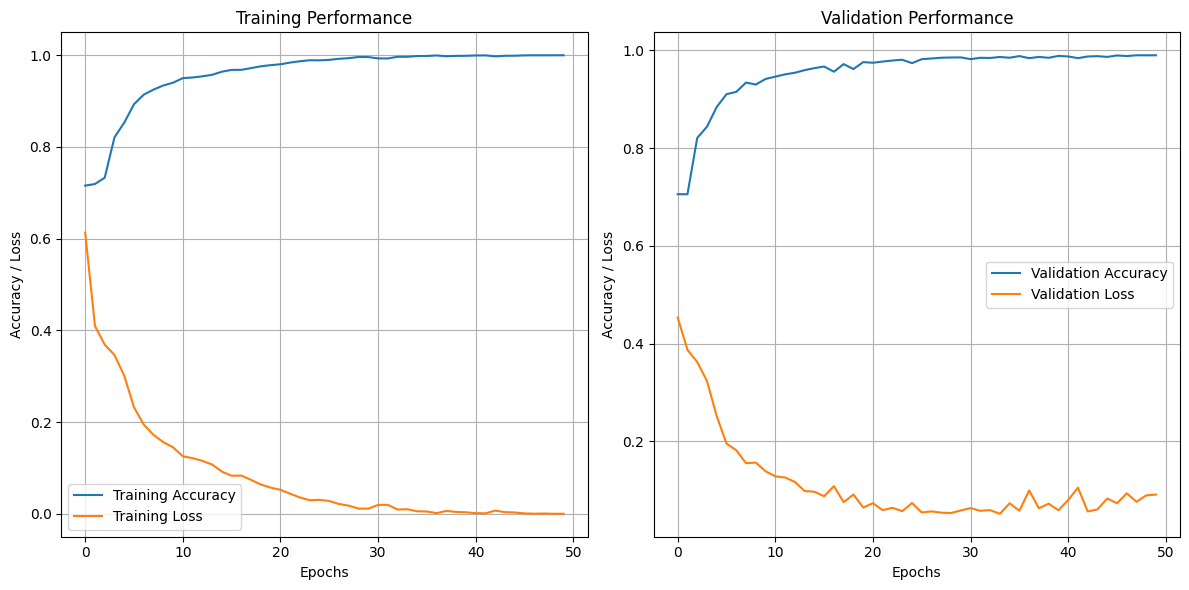


 1/36 [..............................] - ETA: 4:22 - loss: 0.0179 - accuracy: 0.9969


 3/36 [=>............................] - ETA: 2s - loss: 0.1638 - accuracy: 0.9870  


 5/36 [===>..........................] - ETA: 2s - loss: 0.1149 - accuracy: 0.9888


 7/36 [====>.........................] - ETA: 2s - loss: 0.0833 - accuracy: 0.9916


 9/36 [======>.......................] - ETA: 2s - loss: 0.0742 - accuracy: 0.9918


11/36 [========>.....................] - ETA: 1s - loss: 0.0709 - accuracy: 0.9913


13/36 [=========>....................] - ETA: 1s - loss: 0.0723 - accuracy: 0.9906


15/36 [===========>..................] - ETA: 1s - loss: 0.0804 - accuracy: 0.9899


17/36 [=============>................] - ETA: 1s - loss: 0.0723 - accuracy: 0.9907


19/36 [==============>...............] - ETA: 1s - loss: 0.0693 - accuracy: 0.9906


21/36 [================>.............] - ETA: 1s - loss: 0.0670 - accuracy: 0.9908


23/36 [==================>...........] - ETA: 1s - loss: 0.0678 - accuracy: 0.9907


25/36 [===================>..........] - ETA: 0s - loss: 0.0647 - accuracy: 0.9911


27/36 [=====================>........] - ETA: 0s - loss: 0.0674 - accuracy: 0.9907


29/36 [=======================>......] - ETA: 0s - loss: 0.0648 - accuracy: 0.9908


30/36 [========================>.....] - ETA: 0s - loss: 0.0654 - accuracy: 0.9905


32/36 [=========================>....] - ETA: 0s - loss: 0.0860 - accuracy: 0.9898


34/36 [===========================>..] - ETA: 0s - loss: 0.0884 - accuracy: 0.9897


36/36 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9896


36/36 [==============================] - 16s 230ms/step - loss: 0.0914 - accuracy: 0.9896


Validation Loss: 0.09136933088302612
Validation Accuracy: 0.9896164536476135


In [9]:
# Training Graph: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training Performance')
plt.legend()
plt.grid(True)

# Validation Graph: Accuracy and Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Validation Performance')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the validation (split) set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 163ms/step


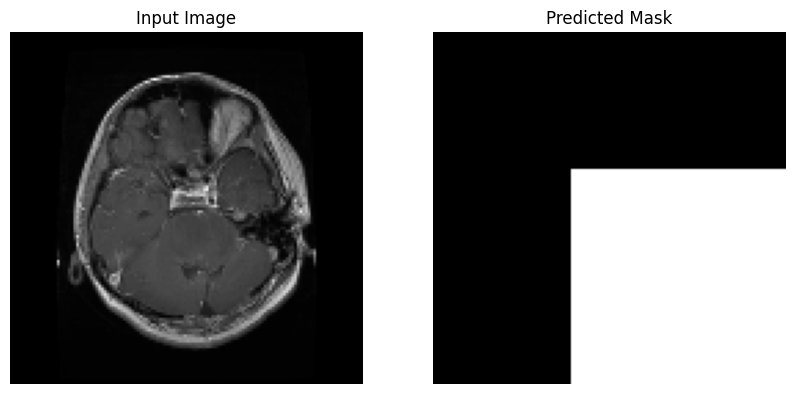

In [10]:
# Test the model on a single image
def test_segmentation(model, image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize
    img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension
    
    # Predict the mask
    prediction = model.predict(img)
    predicted_mask = (prediction > 0.5).astype(np.uint8)  # Threshold the output to get binary mask

    # Plot the input image and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

# Test the model on a sample image
test_image_path = os.path.join(os.environ['DATASET_PATH'], 'Testing/glioma/Te-gl_0010.jpg')
test_segmentation(model, test_image_path)